In [1]:
# ================================================================================================
# OBESITY LEVEL PREDICTION USING MACHINE LEARNING
# Advanced Data Science and Analytics Implementation
# ================================================================================================

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore, chi2_contingency, ttest_rel
from tqdm import tqdm
from itertools import product
import pickle
import os

# Configure visualization parameters for better visibility
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)  # Larger default size
plt.rcParams['font.size'] = 14  # Bigger font
plt.rcParams['axes.titlesize'] = 18  # Bigger title
plt.rcParams['axes.labelsize'] = 16  # Bigger labels

In [2]:
# ================================================================================================
# DATA UNDERSTANDING
# ================================================================================================

# Load dataset and perform initial assessment
data = pd.read_csv('../data/obesity_data.csv')

# Display first few rows to understand data structure
print("=== INITIAL DATA INSPECTION ===")
print("First 5 rows of the dataset:")
print(data.head())
print("\nColumn names and data types:")
print(data.dtypes)

# Dataset dimensional analysis
print(f"\n=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {data.shape}")
print(f"Memory Usage: {data.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"Missing Values: {data.isnull().sum().sum()}")
print(f"Duplicate Records: {data.duplicated().sum()}")

# Group duplicates by all columns
duplicate_groups = data[data.duplicated(keep=False)].sort_values(by=list(data.columns))
print(duplicate_groups)

# Data type examination
print("\nData types distribution:")
print(data.dtypes.value_counts())

# Target variable distribution analysis
target_distribution = data['NObeyesdad'].value_counts().sort_index()
print("\n=== TARGET VARIABLE ANALYSIS ===")
print("Target Variable Distribution:")
for level, count in target_distribution.items():
    percentage = (count / len(data)) * 100
    print(f"{level}: {count:,} ({percentage:.1f}%)")

# Feature categorization for systematic analysis
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
target_feature = 'NObeyesdad'

print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Categorical feature analysis
print("\n=== CATEGORICAL FEATURES ANALYSIS ===")
for feature in categorical_features:
    unique_count = data[feature].nunique()
    mode_value = data[feature].mode()[0]
    mode_freq = (data[feature] == mode_value).sum()
    mode_percentage = (mode_freq / len(data)) * 100
    print(f"{feature}: {unique_count} categories, Mode: {mode_value} ({mode_percentage:.1f}%)")
    print(f"  Unique values: {list(data[feature].unique())}")

# Statistical summary for numerical features
numerical_summary = data[numerical_features].describe().round(3)
print("\n=== NUMERICAL FEATURES STATISTICAL SUMMARY ===")
print(numerical_summary)

# Correlation analysis for multicollinearity detection
correlation_matrix = data[numerical_features].corr()
print("\n=== CORRELATION ANALYSIS ===")
print("Correlation matrix:")
print(correlation_matrix.round(3))

high_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

if high_correlations:
    print("\nHigh Correlations (|r| > 0.7):")
    for feat1, feat2, corr in high_correlations:
        print(f"{feat1} - {feat2}: {corr:.3f}")
else:
    print("\nNo high correlations (|r| > 0.7) found between numerical features")

=== INITIAL DATA INSPECTION ===
First 5 rows of the dataset:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transport


TARGET VARIABLE VISUALIZATION


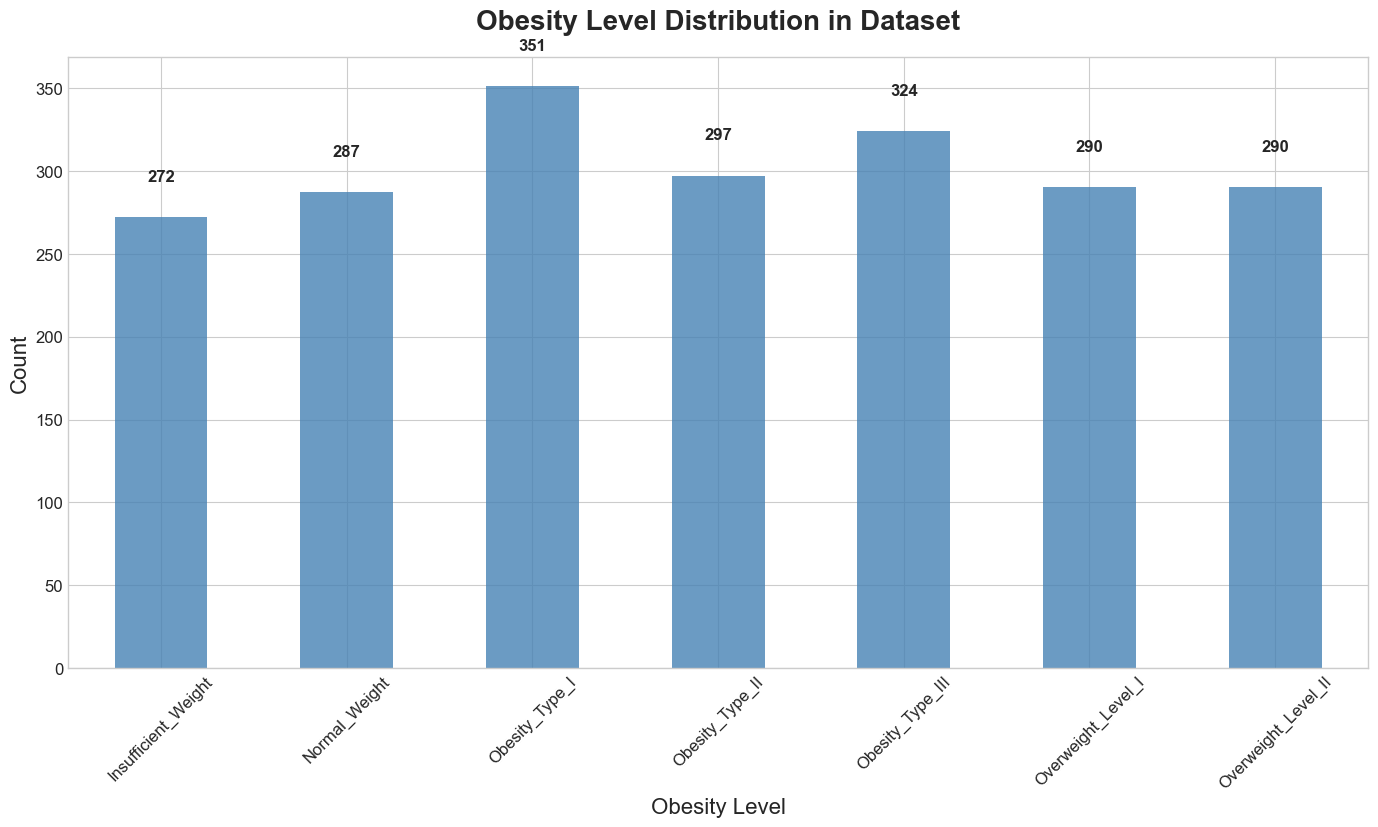



FEATURE CORRELATION ANALYSIS


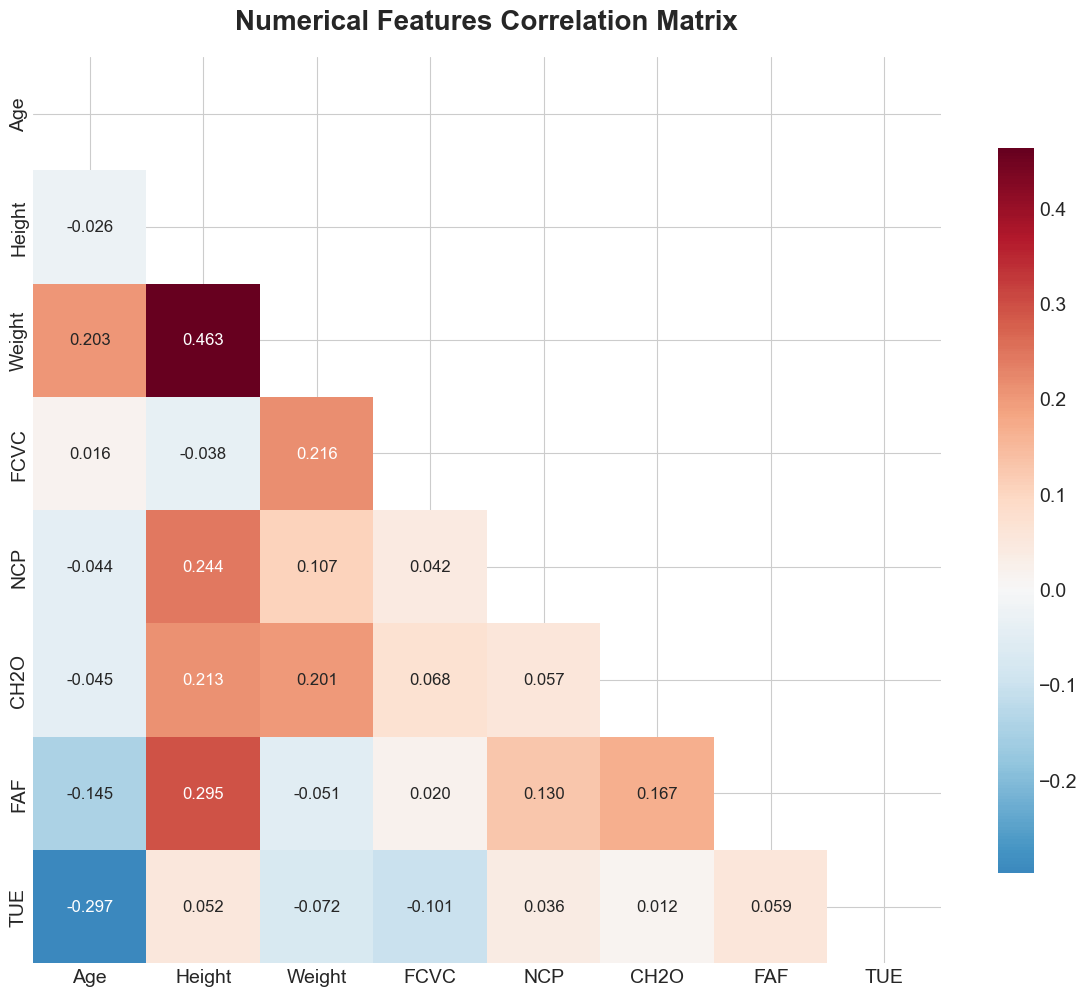



DEMOGRAPHIC DISTRIBUTIONS


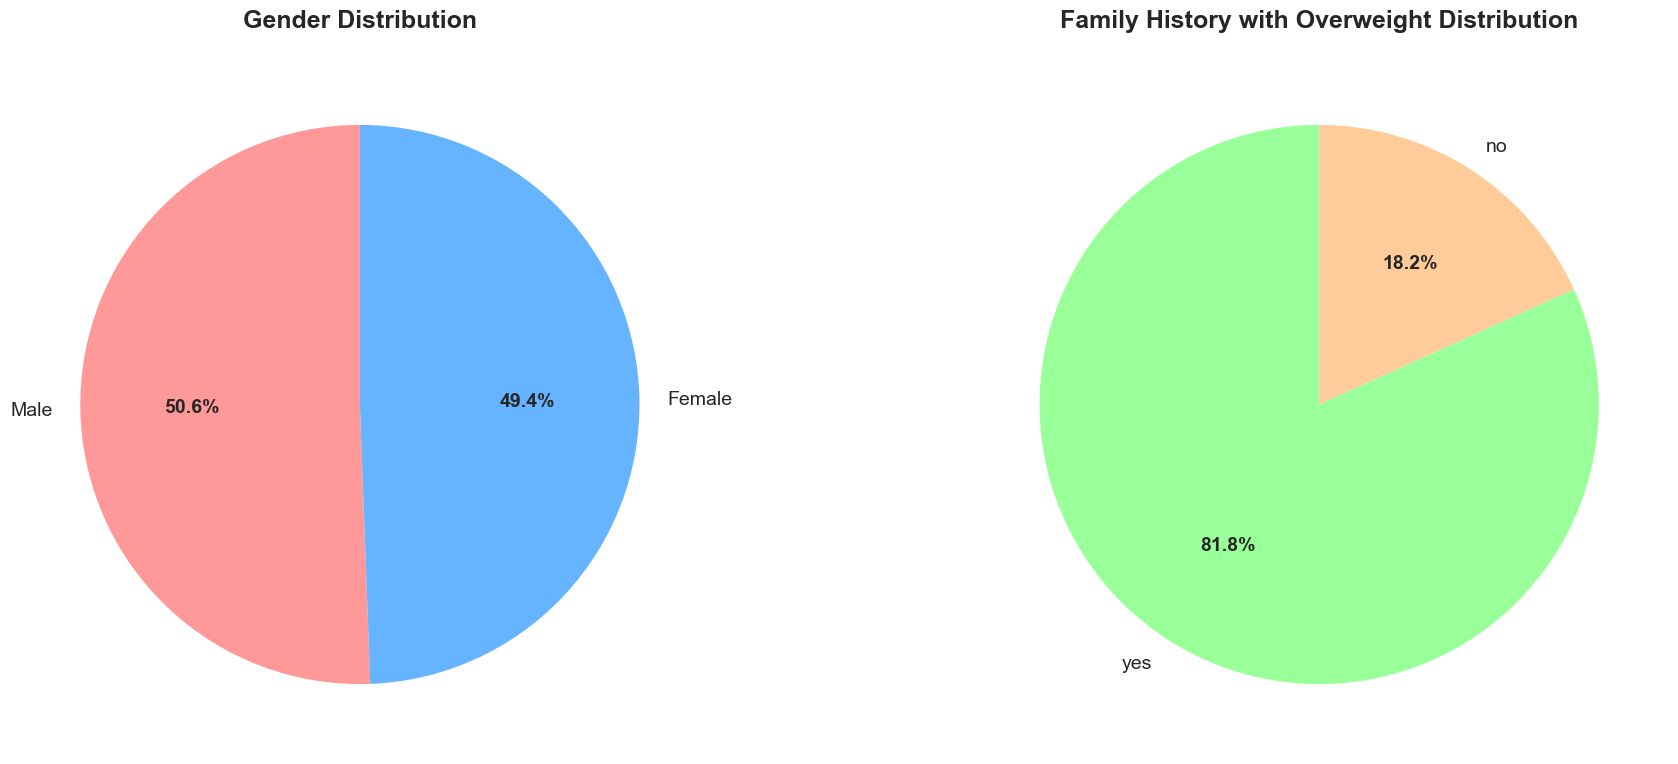



EATING BEHAVIOR DISTRIBUTIONS


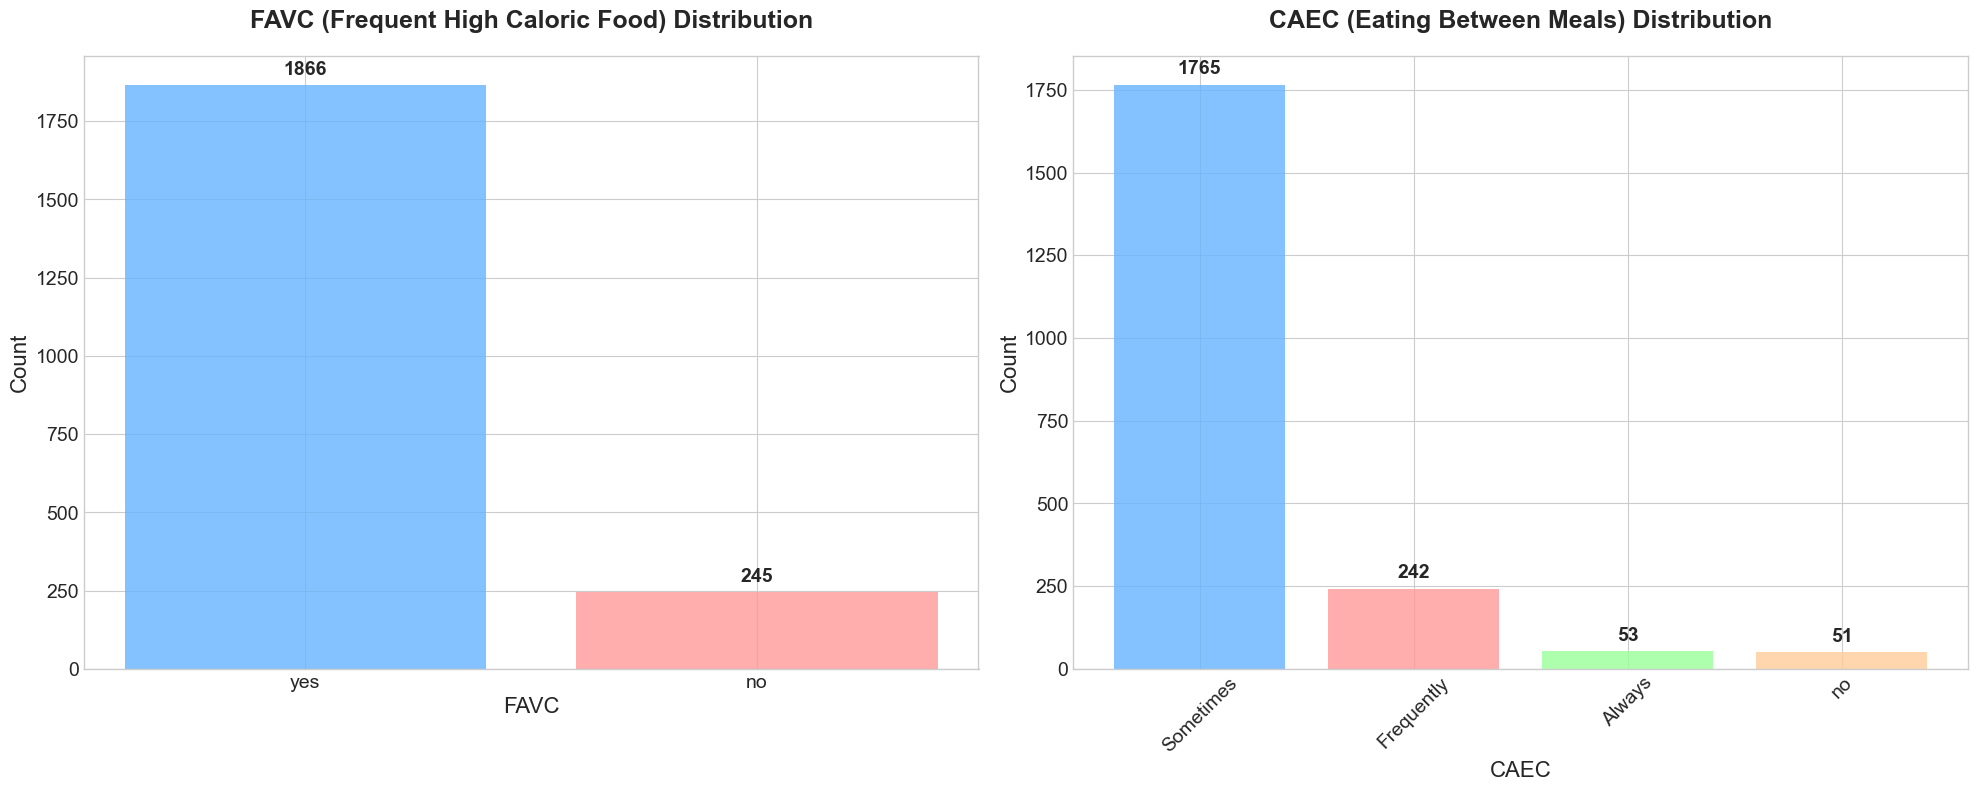



LIFESTYLE & TRANSPORTATION DISTRIBUTIONS


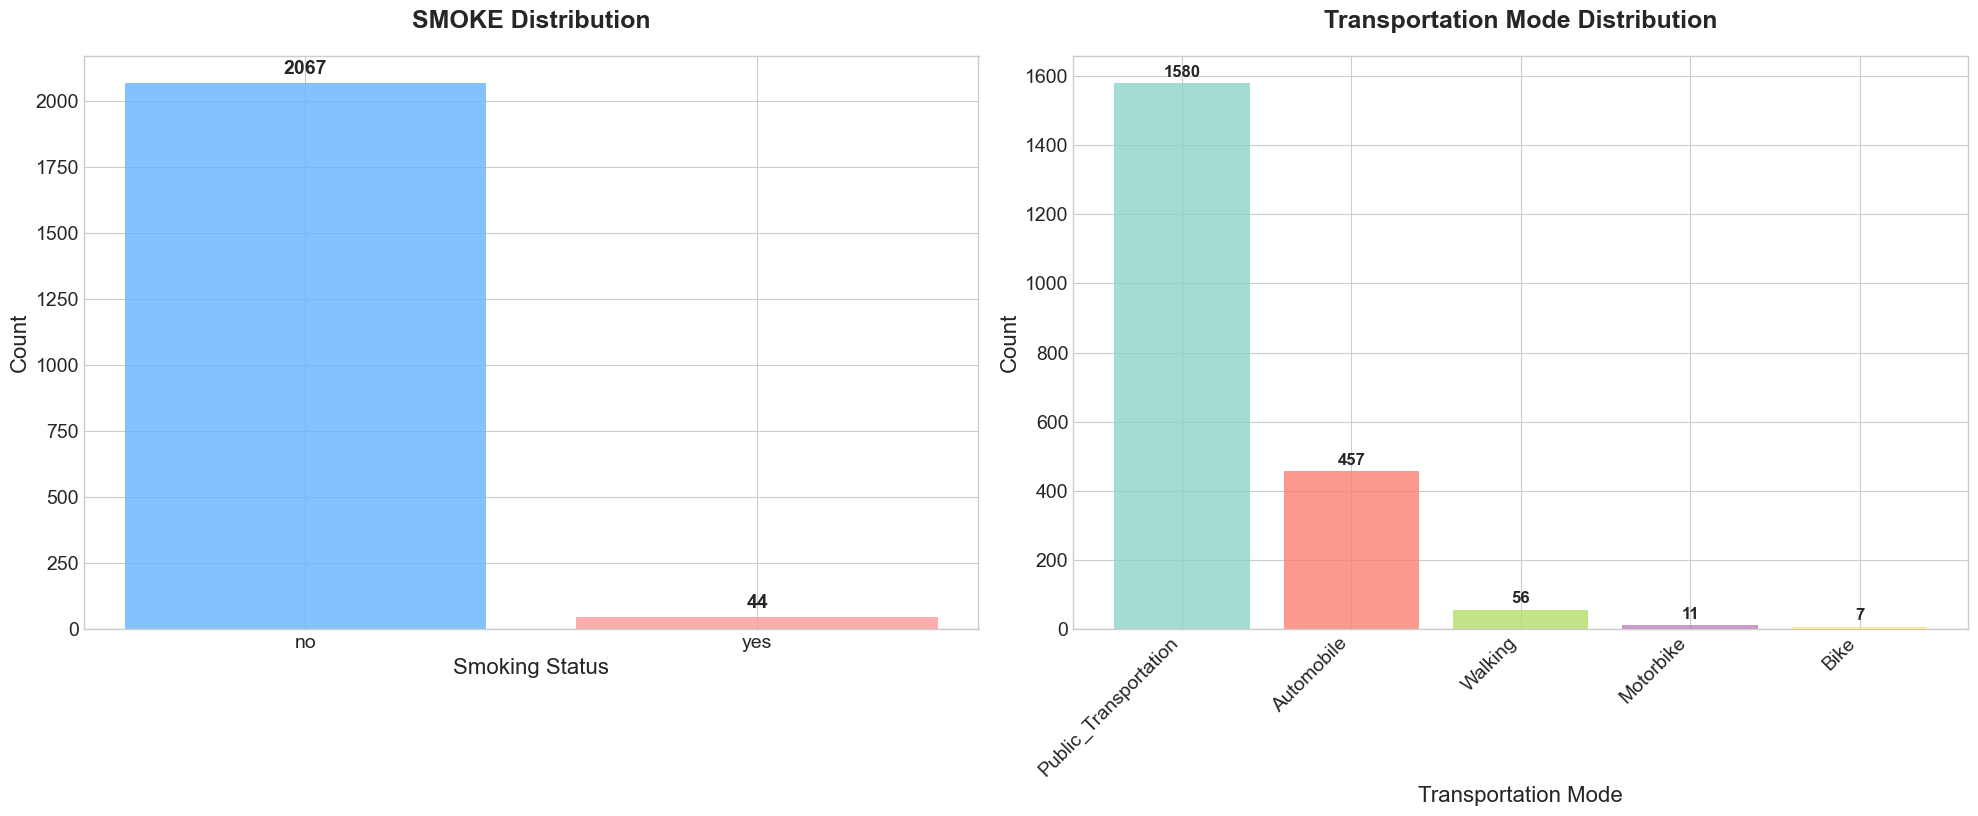



NUMERICAL FEATURES DISTRIBUTION BY OBESITY LEVEL

Analyzing features: Age, Height


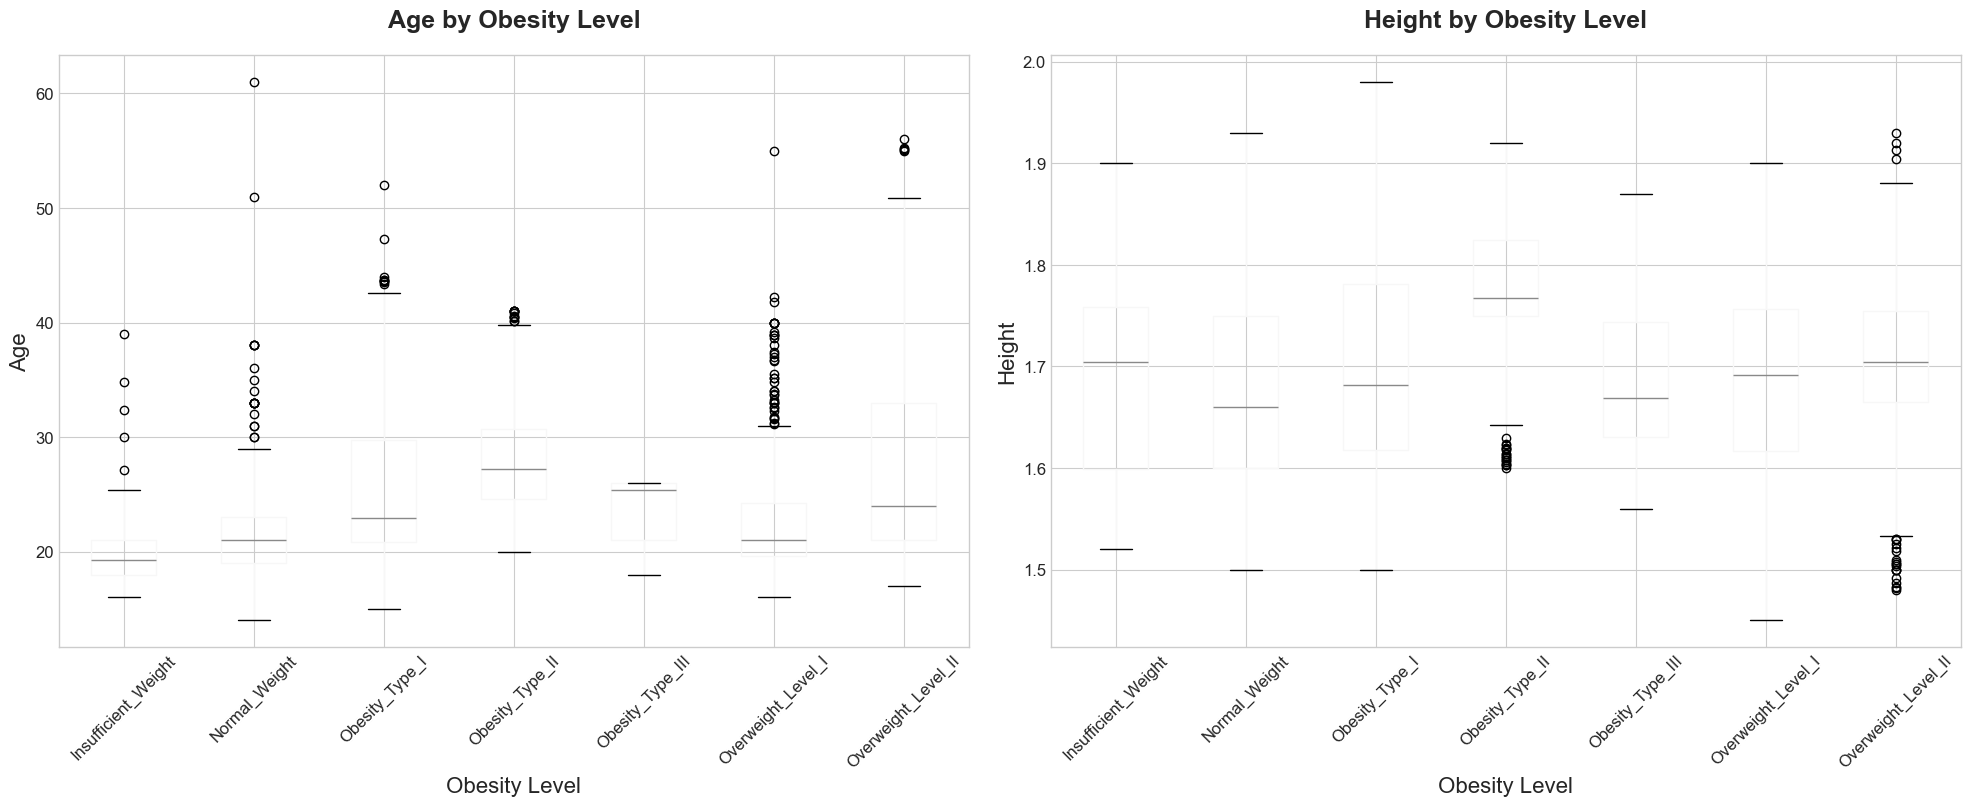


----------------------------------------


Analyzing features: Weight, FCVC


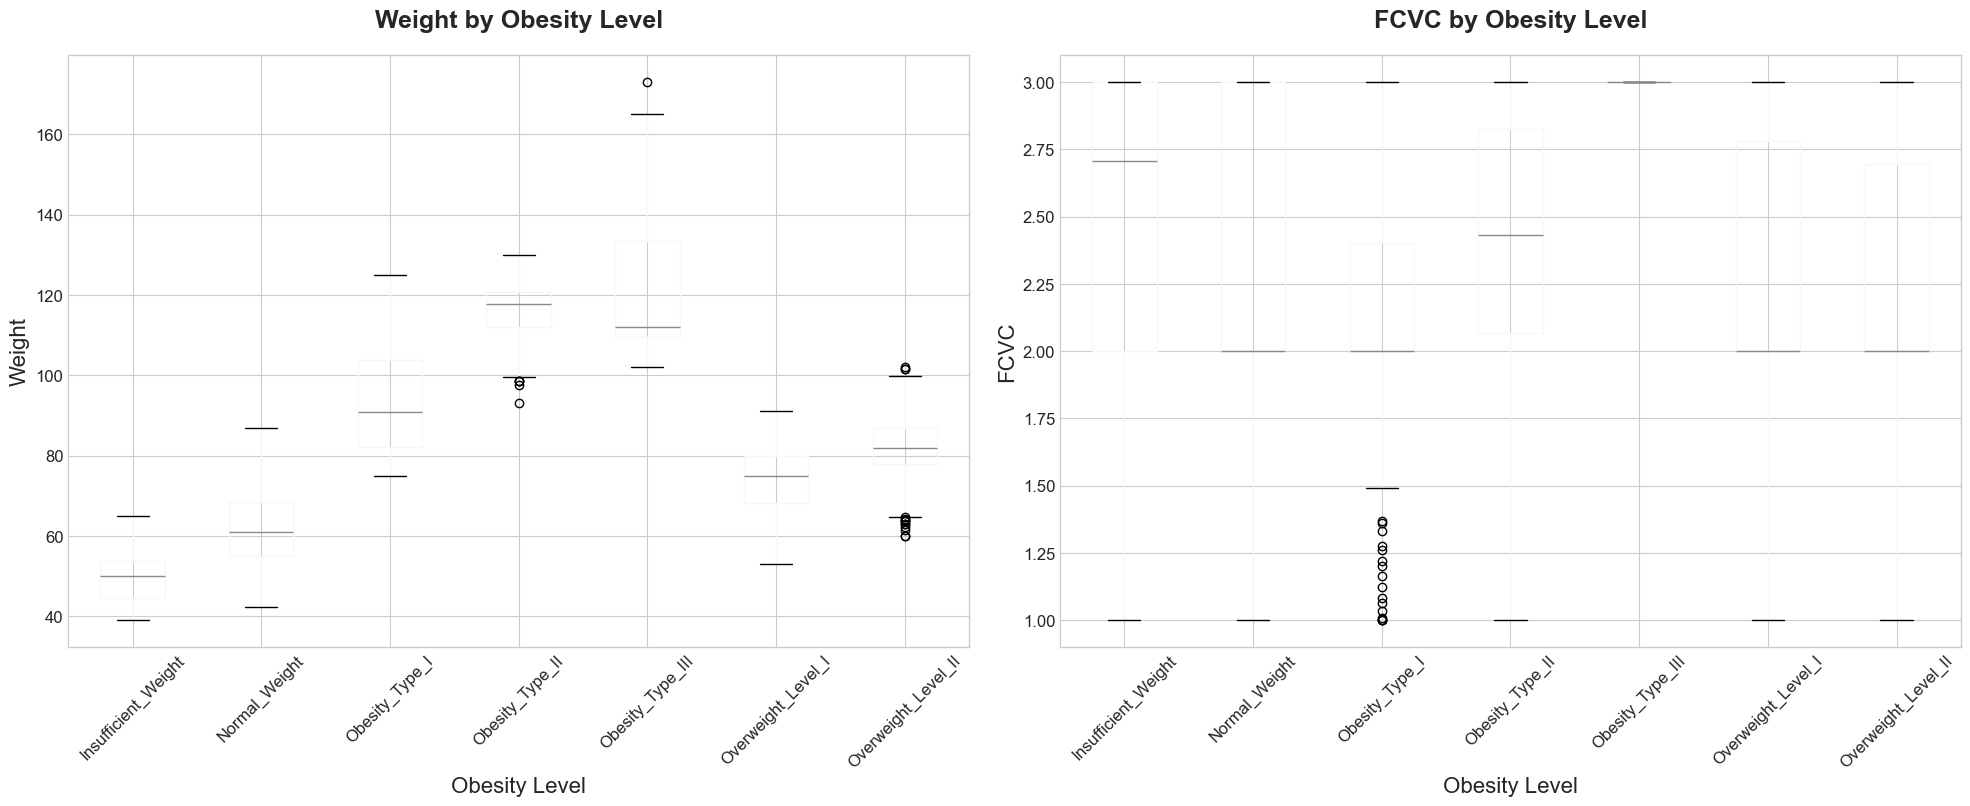


----------------------------------------


Analyzing features: NCP, CH2O


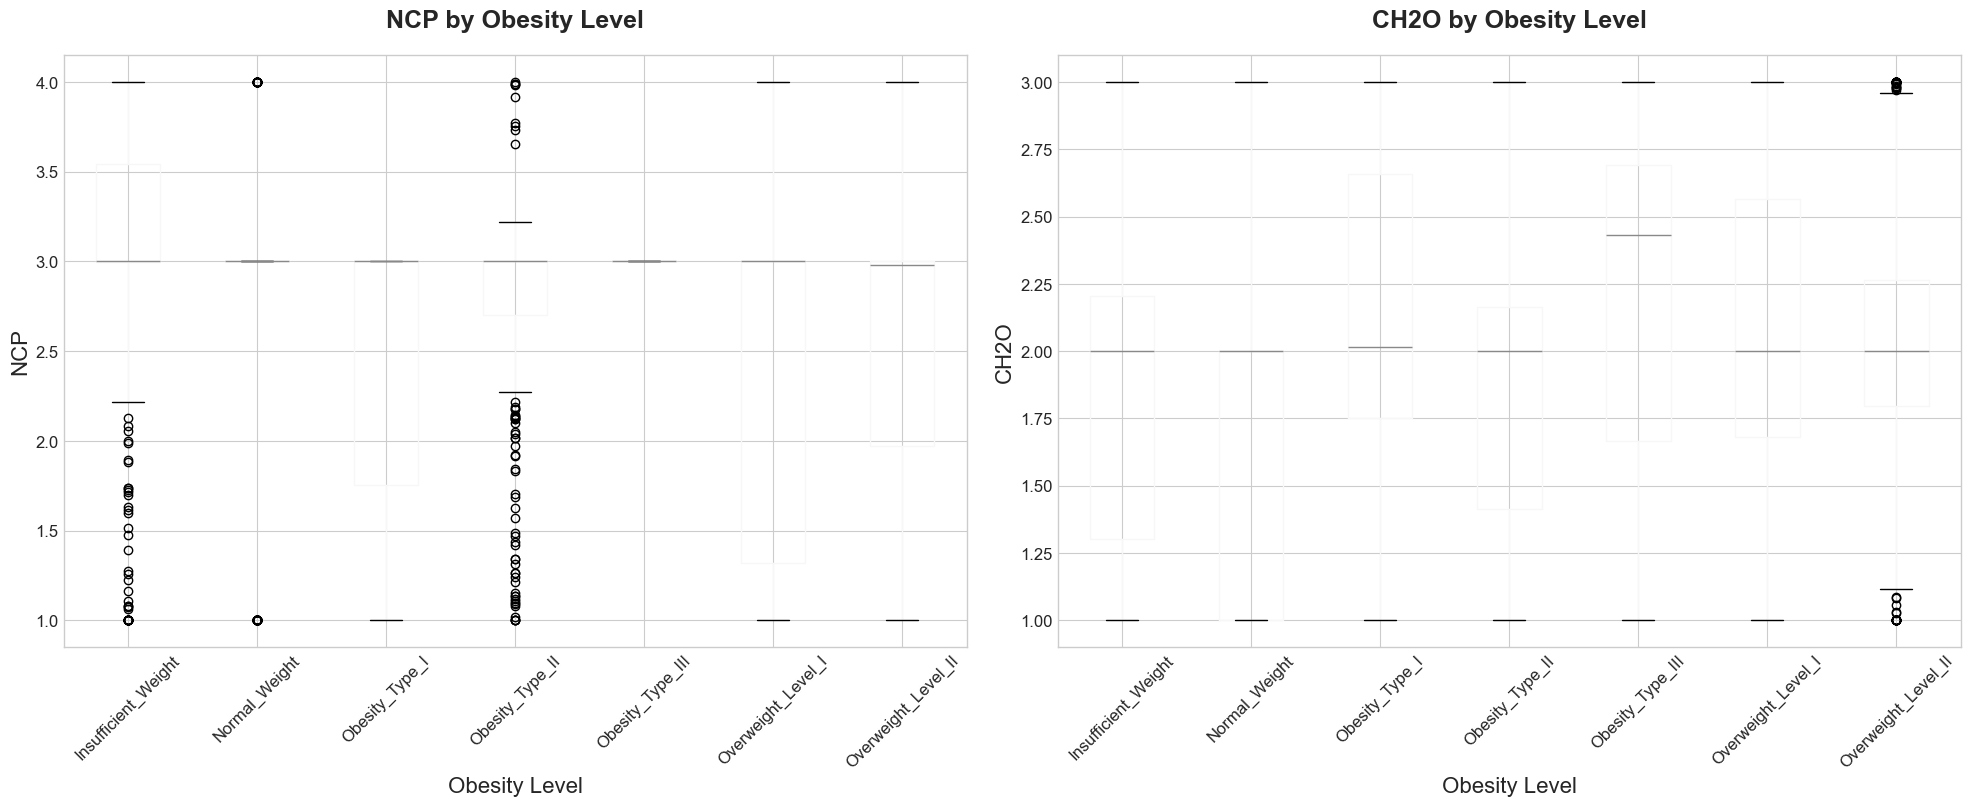


----------------------------------------


Analyzing features: FAF, TUE


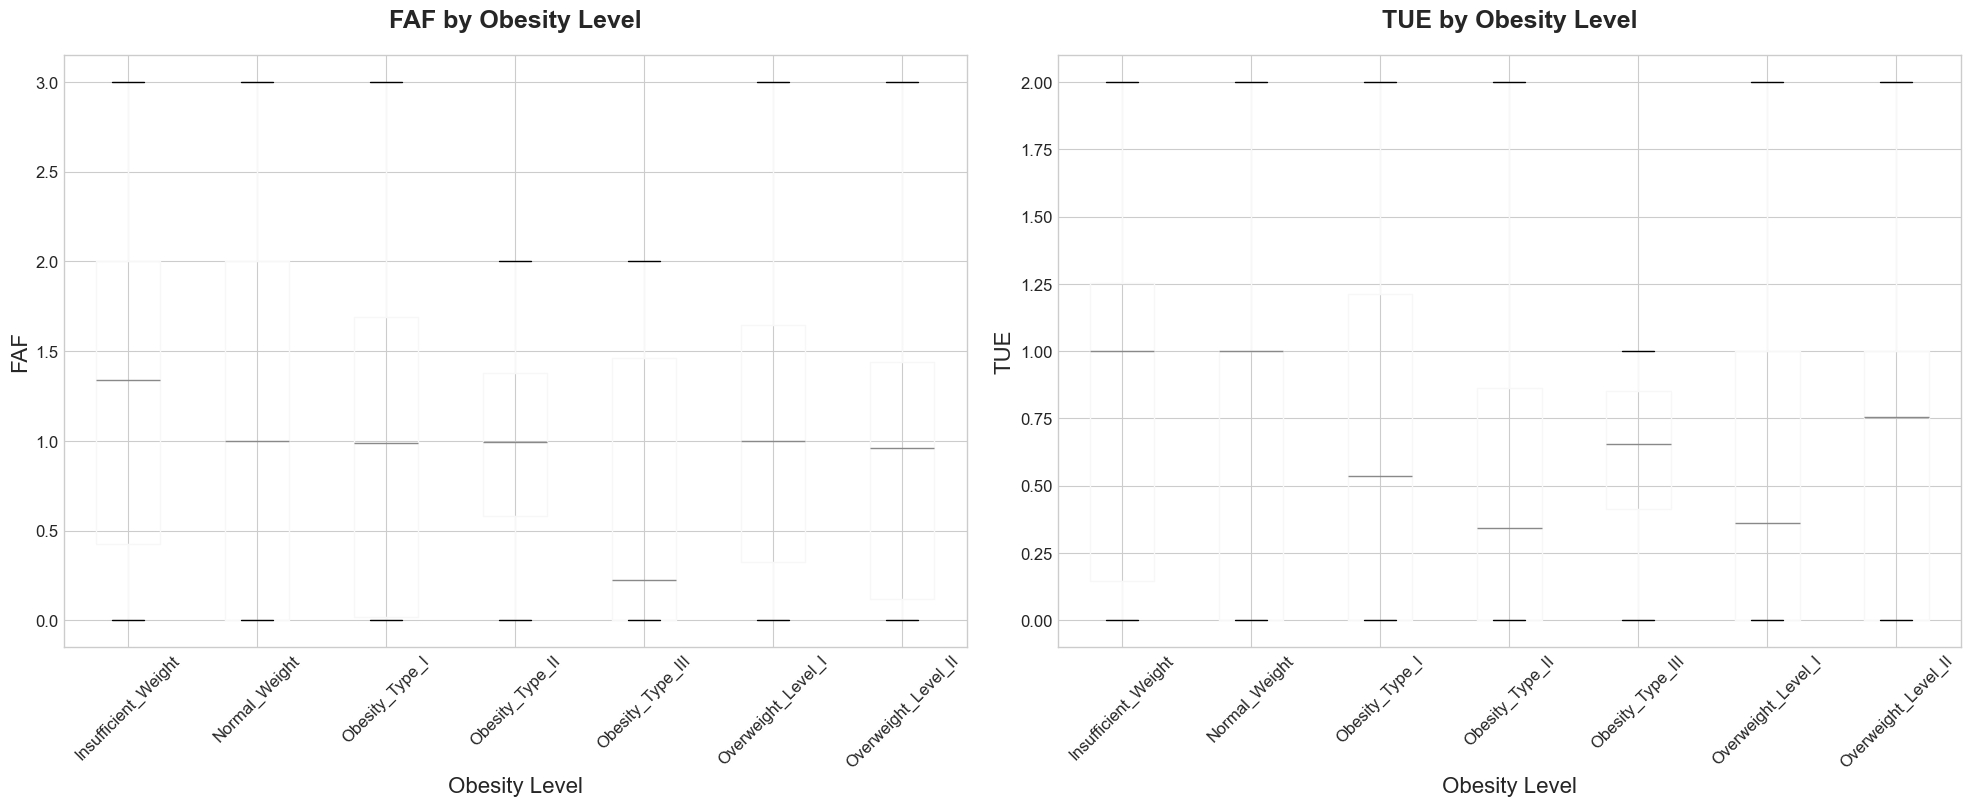


----------------------------------------



In [3]:
# Target distribution visualization - BIGGER AND CLEARER
print("\n" + "="*60)
print("TARGET VARIABLE VISUALIZATION")
print("="*60)

fig, ax = plt.subplots(figsize=(14, 8))
bars = target_distribution.plot(kind='bar', ax=ax, color='steelblue', alpha=0.8)
ax.set_title('Obesity Level Distribution in Dataset', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Obesity Level', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add value labels on bars
for i, v in enumerate(target_distribution.values):
    ax.text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("\n")

# Correlation heatmap - BIGGER AND CLEARER
print("="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, ax=ax, cbar_kws={"shrink": .8}, annot_kws={'size': 12})
ax.set_title('Numerical Features Correlation Matrix', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print("\n")

# Gender and Family History Distribution - 2 charts per row maximum
print("="*60)
print("DEMOGRAPHIC DISTRIBUTIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Gender distribution
gender_counts = data['Gender'].value_counts()
wedges, texts, autotexts = axes[0].pie(gender_counts.values, labels=gender_counts.index, 
                                      autopct='%1.1f%%', startangle=90, 
                                      colors=['#ff9999', '#66b3ff'], textprops={'fontsize': 14})
axes[0].set_title('Gender Distribution', fontsize=18, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

# Family history distribution  
family_counts = data['family_history_with_overweight'].value_counts()
wedges, texts, autotexts = axes[1].pie(family_counts.values, labels=family_counts.index,
                                      autopct='%1.1f%%', startangle=90,
                                      colors=['#99ff99', '#ffcc99'], textprops={'fontsize': 14})
axes[1].set_title('Family History with Overweight Distribution', fontsize=18, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("\n")

# FAVC and CAEC Distribution - 2 charts per row
print("="*60)
print("EATING BEHAVIOR DISTRIBUTIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# FAVC distribution
favc_counts = data['FAVC'].value_counts()
bars1 = axes[0].bar(favc_counts.index, favc_counts.values, color=['#66b3ff', '#ff9999'], alpha=0.8)
axes[0].set_title('FAVC (Frequent High Caloric Food) Distribution', fontsize=18, fontweight='bold', pad=20)
axes[0].set_xlabel('FAVC', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].tick_params(labelsize=14)
for i, v in enumerate(favc_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold', fontsize=14)

# CAEC distribution
caec_counts = data['CAEC'].value_counts()
bars2 = axes[1].bar(range(len(caec_counts)), caec_counts.values, 
                   color=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'], alpha=0.8)
axes[1].set_title('CAEC (Eating Between Meals) Distribution', fontsize=18, fontweight='bold', pad=20)
axes[1].set_xlabel('CAEC', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_xticks(range(len(caec_counts)))
axes[1].set_xticklabels(caec_counts.index, rotation=45)
axes[1].tick_params(labelsize=14)
for i, v in enumerate(caec_counts.values):
    axes[1].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("\n")

# SMOKE and Transportation Distribution - 2 charts per row  
print("="*60)
print("LIFESTYLE & TRANSPORTATION DISTRIBUTIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# SMOKE distribution
smoke_counts = data['SMOKE'].value_counts()
bars1 = axes[0].bar(smoke_counts.index, smoke_counts.values, color=['#66b3ff', '#ff9999'], alpha=0.8)
axes[0].set_title('SMOKE Distribution', fontsize=18, fontweight='bold', pad=20)
axes[0].set_xlabel('Smoking Status', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].tick_params(labelsize=14)
for i, v in enumerate(smoke_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold', fontsize=14)

# Transportation distribution
transport_counts = data['MTRANS'].value_counts()
bars2 = axes[1].bar(range(len(transport_counts)), transport_counts.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(transport_counts))), alpha=0.8)
axes[1].set_title('Transportation Mode Distribution', fontsize=18, fontweight='bold', pad=20)
axes[1].set_xlabel('Transportation Mode', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_xticks(range(len(transport_counts)))
axes[1].set_xticklabels(transport_counts.index, rotation=45, ha='right')
axes[1].tick_params(labelsize=14)
for i, v in enumerate(transport_counts.values):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

print("\n")

# Box plot analysis - 2 plots per row for better visibility
print("="*60)
print("NUMERICAL FEATURES DISTRIBUTION BY OBESITY LEVEL")
print("="*60)

numerical_features_pairs = [(numerical_features[i:i+2]) for i in range(0, len(numerical_features), 2)]

for pair_idx, pair in enumerate(numerical_features_pairs):
    print(f"\nAnalyzing features: {', '.join(pair)}")
    
    fig, axes = plt.subplots(1, len(pair), figsize=(20, 8))
    if len(pair) == 1:
        axes = [axes]
    
    for i, feature in enumerate(pair):
        data.boxplot(column=feature, by='NObeyesdad', ax=axes[i])
        axes[i].set_title(f'{feature} by Obesity Level', fontsize=18, fontweight='bold', pad=20)
        axes[i].set_xlabel('Obesity Level', fontsize=16)
        axes[i].set_ylabel(feature, fontsize=16)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
    
    plt.suptitle('')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    print("\n" + "-"*40)
    print()

In [4]:
# Outlier detection using IQR methodology
print("\n=== OUTLIER DETECTION ANALYSIS ===")
outlier_analysis = {}
for feature in numerical_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    
    outlier_analysis[feature] = {
        'count': len(outliers),
        'percentage': len(outliers) / len(data) * 100
    }
    print(f"{feature}: {len(outliers)} outliers ({len(outliers)/len(data)*100:.2f}%)")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Statistical significance testing for categorical relationships
print("\n=== STATISTICAL SIGNIFICANCE TESTING ===")
for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], data['NObeyesdad'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"{feature} vs Target:")
    print(f"  Chi-square statistic: {chi2_stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")


=== OUTLIER DETECTION ANALYSIS ===
Age: 168 outliers (7.96%)
  Q1: 19.95, Q3: 26.00, IQR: 6.05
  Lower bound: 10.87, Upper bound: 35.08
Height: 1 outliers (0.05%)
  Q1: 1.63, Q3: 1.77, IQR: 0.14
  Lower bound: 1.42, Upper bound: 1.98
Weight: 1 outliers (0.05%)
  Q1: 65.47, Q3: 107.43, IQR: 41.96
  Lower bound: 2.54, Upper bound: 170.37
FCVC: 0 outliers (0.00%)
  Q1: 2.00, Q3: 3.00, IQR: 1.00
  Lower bound: 0.50, Upper bound: 4.50
NCP: 579 outliers (27.43%)
  Q1: 2.66, Q3: 3.00, IQR: 0.34
  Lower bound: 2.15, Upper bound: 3.51
CH2O: 0 outliers (0.00%)
  Q1: 1.58, Q3: 2.48, IQR: 0.89
  Lower bound: 0.25, Upper bound: 3.82
FAF: 0 outliers (0.00%)
  Q1: 0.12, Q3: 1.67, IQR: 1.54
  Lower bound: -2.19, Upper bound: 3.98
TUE: 0 outliers (0.00%)
  Q1: 0.00, Q3: 1.00, IQR: 1.00
  Lower bound: -1.50, Upper bound: 2.50

=== STATISTICAL SIGNIFICANCE TESTING ===
Gender vs Target:
  Chi-square statistic: 657.75
  p-value: 0.0000
  Degrees of freedom: 6
  Significant: Yes
family_history_with_overwei

In [5]:
# ================================================================================================
# DATA PREPARATION
# ================================================================================================

print("\n" + "="*80)
print("DATA PREPARATION PHASE")
print("="*80)

# Create working dataset copy for preprocessing
df_processed = data.copy()
print(f"Original dataset shape: {df_processed.shape}")
print("Original dataset columns:", list(df_processed.columns))

# Show sample data before processing
print("\nSample data BEFORE processing:")
print(df_processed.head(3))

# Advanced feature engineering
print("\n=== FEATURE ENGINEERING ===")
df_processed['BMI'] = df_processed['Weight'] / (df_processed['Height'] ** 2)
df_processed['Weight_Height_Ratio'] = df_processed['Weight'] / df_processed['Height']
df_processed['Physical_Activity_Score'] = df_processed['FAF'] * df_processed['CH2O']
df_processed['Age_Weight_Interaction'] = df_processed['Age'] * df_processed['Weight'] / 100

print("Added 4 numerical engineered features:")
print("1. BMI = Weight / Height²")
print("2. Weight_Height_Ratio = Weight / Height") 
print("3. Physical_Activity_Score = FAF * CH2O")
print("4. Age_Weight_Interaction = (Age * Weight) / 100")

# Show effect of feature engineering
print(f"\nDataset shape after numerical feature engineering: {df_processed.shape}")
print("\nNew numerical features sample:")
new_numerical_cols = ['BMI', 'Weight_Height_Ratio', 'Physical_Activity_Score', 'Age_Weight_Interaction']
print(df_processed[new_numerical_cols].head())
print("\nStatistics for new numerical features:")
print(df_processed[new_numerical_cols].describe())

# Lifestyle risk assessment scoring
df_processed['Lifestyle_Risk_Score'] = (
    (df_processed['FAVC'] == 'yes').astype(int) * 2 + 
    (df_processed['SMOKE'] == 'yes').astype(int) * 3 + 
    (df_processed['SCC'] == 'no').astype(int) * 1
)

# Health risk index calculation
df_processed['Health_Risk_Index'] = (
    (df_processed['FAVC'] == 'yes').astype(int) * 0.3 +
    (df_processed['SMOKE'] == 'yes').astype(int) * 0.4 +
    (df_processed['FAF'] < 1).astype(int) * 0.3
)

# Eating pattern behavioral scoring
df_processed['Eating_Pattern_Score'] = df_processed['FCVC'] * df_processed['NCP'] / df_processed['TUE'].clip(lower=1)

print("\nAdded 3 behavioral scoring features:")
print("5. Lifestyle_Risk_Score (based on FAVC, SMOKE, SCC)")
print("6. Health_Risk_Index (weighted risk assessment)")  
print("7. Eating_Pattern_Score (eating behavior pattern)")

print(f"\nDataset shape after all feature engineering: {df_processed.shape}")
behavioral_cols = ['Lifestyle_Risk_Score', 'Health_Risk_Index', 'Eating_Pattern_Score']
print("\nNew behavioral features sample:")
print(df_processed[behavioral_cols].head())

# Categorical binning for continuous variables
print("\n=== CATEGORICAL BINNING ===")
df_processed['Age_Category'] = pd.cut(df_processed['Age'], 
                                    bins=[0, 25, 35, 50, 100], 
                                    labels=['Young', 'Adult', 'MiddleAge', 'Senior'])

df_processed['BMI_WHO_Category'] = pd.cut(df_processed['BMI'], 
                                        bins=[0, 18.5, 25, 30, 35, 50], 
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese_I', 'Obese_II'])

df_processed['Hydration_Level'] = pd.cut(df_processed['CH2O'], 
                                       bins=[0, 1.5, 2.5, 4], 
                                       labels=['Low', 'Moderate', 'High'])

df_processed['Activity_Level'] = pd.cut(df_processed['FAF'], 
                                      bins=[0, 1, 2, 3], 
                                      labels=['Sedentary', 'Light', 'Active'])

print("Created 4 categorical bins from continuous variables:")
print("- Age_Category: Young(≤25), Adult(26-35), MiddleAge(36-50), Senior(>50)")
print("- BMI_WHO_Category: WHO standard BMI categories") 
print("- Hydration_Level: Low(≤1.5L), Moderate(1.5-2.5L), High(>2.5L)")
print("- Activity_Level: Sedentary(<1), Light(1-2), Active(≥2)")

print(f"\nDataset shape after adding categorical features: {df_processed.shape}")

# Show effect of binning
print("\nAge category distribution:")
print(df_processed['Age_Category'].value_counts())
print("\nBMI WHO category distribution:")
print(df_processed['BMI_WHO_Category'].value_counts())

# Binary categorical variable encoding
print("\n=== BINARY ENCODING ===")
label_encoder = LabelEncoder()
binary_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

print("Before encoding - binary features sample:")
print(df_processed[binary_features].head())

for feature in binary_features:
    if feature in df_processed.columns:
        original_values = df_processed[feature].unique()
        df_processed[feature] = label_encoder.fit_transform(df_processed[feature])
        new_values = df_processed[feature].unique()
        print(f"{feature}: {original_values} -> {new_values}")

print("\nAfter encoding - binary features sample:")
print(df_processed[binary_features].head())

# One-hot encoding for multi-categorical variables
print("\n=== ONE-HOT ENCODING ===")
multi_categorical = ['CAEC', 'CALC', 'MTRANS', 'Age_Category', 'BMI_WHO_Category', 
                    'Hydration_Level', 'Activity_Level']

print(f"Shape before one-hot encoding: {df_processed.shape}")
print(f"Multi-categorical features to encode: {multi_categorical}")

for feature in multi_categorical:
    if feature in df_processed.columns:
        print(f"{feature} unique values: {df_processed[feature].unique()}")

df_processed = pd.get_dummies(df_processed, columns=multi_categorical, prefix=multi_categorical, drop_first=True)

print(f"Shape after one-hot encoding: {df_processed.shape}")
print("New one-hot encoded columns created:")
new_columns = [col for col in df_processed.columns if any(prefix in col for prefix in multi_categorical)]
print(new_columns)

# Target variable ordinal encoding
print("\n=== TARGET VARIABLE ENCODING ===")
target_mapping = {
    'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2,
    'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6
}

print("Target mapping:")
for k, v in target_mapping.items():
    print(f"  {k} -> {v}")

df_processed['NObeyesdad'] = df_processed['NObeyesdad'].str.replace(' ', '_')
df_processed['target'] = df_processed['NObeyesdad'].map(target_mapping)

print("\nTarget encoding result:")
print("Original vs Encoded:")
target_comparison = pd.DataFrame({
    'Original': df_processed['NObeyesdad'], 
    'Encoded': df_processed['target']
}).drop_duplicates().sort_values('Encoded')
print(target_comparison)

# Statistical outlier removal using z-score methodology
print("\n=== OUTLIER REMOVAL ===")
numerical_cols_extended = ['Age', 'Height', 'Weight', 'BMI', 'CH2O', 'FAF', 'FCVC', 'NCP', 'TUE', 
                          'Weight_Height_Ratio', 'Physical_Activity_Score', 'Age_Weight_Interaction', 
                          'Lifestyle_Risk_Score', 'Health_Risk_Index', 'Eating_Pattern_Score']

print(f"Shape before outlier removal: {df_processed.shape}")
print("Applying z-score outlier removal (threshold = 3)...")

z_scores = np.abs(zscore(df_processed[numerical_cols_extended]))
outlier_mask = (z_scores < 3).all(axis=1)
df_cleaned = df_processed[outlier_mask].copy()

print(f"Shape after outlier removal: {df_cleaned.shape}")
print(f"Samples removed: {len(df_processed) - len(df_cleaned)} ({((len(df_processed) - len(df_cleaned))/len(df_processed)*100):.2f}%)")

# Show final processed dataset
print("\n=== FINAL PROCESSED DATASET ===")
print(f"Final shape: {df_cleaned.shape}")
print("Final columns:", list(df_cleaned.columns))
print("\nSample of final processed data:")
print(df_cleaned.head(3))

# Feature matrix and target vector preparation
X = df_cleaned.drop(columns=['NObeyesdad', 'target'])
y = df_cleaned['target']

print(f"\nFeature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print("X columns:", list(X.columns))
print("\nTarget distribution in y:")
print(pd.Series(y).value_counts().sort_index())

continuous_features = [col for col in numerical_cols_extended if col in X.columns]
print(f"\nContinuous features for scaling ({len(continuous_features)}): {continuous_features}")

# Feature standardization for improved model performance
print("\n=== FEATURE STANDARDIZATION ===")
scaler = StandardScaler()

print("Before standardization - continuous features sample:")
print(X[continuous_features].head())
print("\nBefore standardization - statistics:")
print(X[continuous_features].describe())

X[continuous_features] = scaler.fit_transform(X[continuous_features])

print("\nAfter standardization - continuous features sample:")
print(X[continuous_features].head())
print("\nAfter standardization - statistics:")
print(X[continuous_features].describe())

# Multi-method feature selection approach
print("\n=== FEATURE SELECTION ===")
print(f"Starting with {X.shape[1]} features")

# F-test selection
selector_f_test = SelectKBest(score_func=f_classif, k=30)
X_selected_f = selector_f_test.fit_transform(X, y)
selected_features_f = X.columns[selector_f_test.get_support()].tolist()
print(f"F-test selected {len(selected_features_f)} features")
print("F-test selected features:", selected_features_f[:10], "...")

# Mutual information selection
selector_mutual_info = SelectKBest(score_func=mutual_info_classif, k=30)
X_selected_mi = selector_mutual_info.fit_transform(X, y)
selected_features_mi = X.columns[selector_mutual_info.get_support()].tolist()
print(f"Mutual information selected {len(selected_features_mi)} features")
print("Mutual info selected features:", selected_features_mi[:10], "...")

# RFE selection
rf_for_selection = RandomForestClassifier(n_estimators=100, random_state=42)
selector_rfe = RFE(estimator=rf_for_selection, n_features_to_select=30, step=1)
selector_rfe.fit(X, y)
selected_features_rfe = X.columns[selector_rfe.support_].tolist()
print(f"RFE selected {len(selected_features_rfe)} features")
print("RFE selected features:", selected_features_rfe[:10], "...")

# Feature selection consolidation
combined_features = list(set(selected_features_f + selected_features_mi + selected_features_rfe))
X_final = X[combined_features]
print(f"\nCombined unique features selected: {len(combined_features)}")
print("Final selected features:", combined_features)
print(f"Final feature matrix shape: {X_final.shape}")

# Class imbalance handling using SMOTE
print("\n=== CLASS BALANCING WITH SMOTE ===")
print("Original class distribution:")
original_dist = pd.Series(y).value_counts().sort_index()
print(original_dist)
print("Original class percentages:")
print((original_dist / len(y) * 100).round(2))

smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X_final, y)

print(f"\nOriginal shape: {X_final.shape}")
print(f"Balanced shape: {X_balanced.shape}")

balanced_dist = pd.Series(y_balanced).value_counts().sort_index()
print("\nBalanced class distribution:")
print(balanced_dist)
print("Balanced class percentages:")
print((balanced_dist / len(y_balanced) * 100).round(2))


DATA PREPARATION PHASE
Original dataset shape: (2111, 17)
Original dataset columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

Sample data BEFORE processing:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   

                  MTRANS     NObeyesdad  
0  Public_Transportation  Normal_Weight  
1  Public_Transportation  Normal_Weight  
2  Public_Transportation  Normal_W


CLASS BALANCE COMPARISON


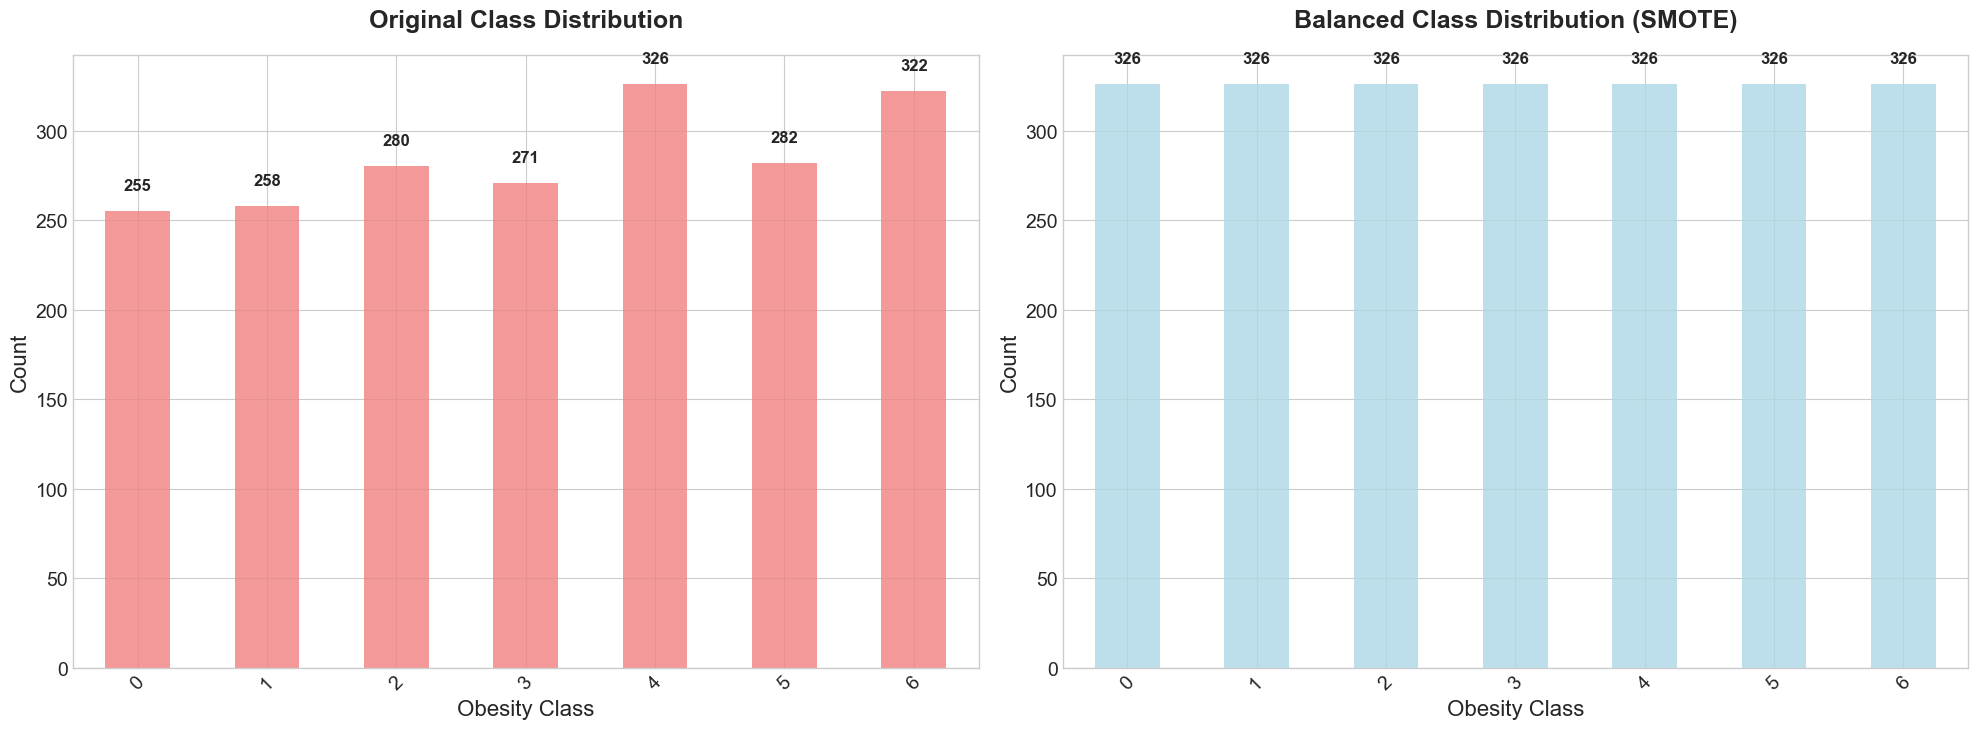


=== TRAIN-TEST SPLIT ===
Training set: (1711, 34)
Testing set: (571, 34)

Training set class distribution:
target
0    245
1    245
2    244
3    244
4    244
5    245
6    244
Name: count, dtype: int64

Testing set class distribution:
target
0    81
1    81
2    82
3    82
4    82
5    81
6    82
Name: count, dtype: int64

Training set sample:
X_train features sample:
      Lifestyle_Risk_Score  Hydration_Level_High  FAVC  CAEC_no    Height  \
2048             -2.910876                 False     0    False  0.439376   
1771              0.351792                 False     1    False -0.618985   
155              -2.910876                  True     0    False  0.849940   

      Health_Risk_Index  Activity_Level_Light      FCVC  \
2048          -1.525500                 False  1.087784   
1771           1.014617                 False  1.087784   
155           -2.317492                 False -0.776729   

      family_history_with_overweight       BMI  ...  CALC_no  \
2048             

In [6]:
# Class balance visualization
print("\n" + "="*60)
print("CLASS BALANCE COMPARISON")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

bars1 = original_dist.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
ax1.set_title('Original Class Distribution', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Obesity Class', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
for i, v in enumerate(original_dist.values):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

bars2 = balanced_dist.plot(kind='bar', ax=ax2, color='lightblue', alpha=0.8)
ax2.set_title('Balanced Class Distribution (SMOTE)', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Obesity Class', fontsize=16)
ax2.set_ylabel('Count', fontsize=16) 
ax2.tick_params(axis='x', rotation=45, labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
for i, v in enumerate(balanced_dist.values):
    ax2.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Train-test dataset partitioning
print("\n=== TRAIN-TEST SPLIT ===")
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

print("\nTraining set sample:")
print("X_train features sample:")
print(X_train.head(3))
print("y_train target sample:")
print(y_train[:10])

In [7]:
# ================================================================================
# MODELLING PHASE
# ================================================================================

print("\n" + "="*80)
print("MODELLING PHASE")
print("="*80)

# Cross-validation strategy configuration
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models_results = {}
baseline_results = {}


MODELLING PHASE


In [8]:
# Random Forest Classifier - Ensemble Method
print("=== RANDOM FOREST CLASSIFIER ===")

# Baseline Random Forest (before tuning)
print("Training baseline Random Forest...")
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)
rf_baseline_pred = rf_baseline.predict(X_test)
rf_baseline_train_pred = rf_baseline.predict(X_train)
rf_baseline_acc = accuracy_score(y_test, rf_baseline_pred)
rf_baseline_train_acc = accuracy_score(y_train, rf_baseline_train_pred)
print(f"Baseline RF test accuracy: {rf_baseline_acc:.4f}")
print(f"Baseline RF train accuracy: {rf_baseline_train_acc:.4f}")

baseline_results['Random Forest'] = {
    'accuracy': rf_baseline_acc,
    'train_accuracy': rf_baseline_train_acc,
    'predictions': rf_baseline_pred
}

# Hyperparameter tuning with tqdm progress
print("Performing hyperparameter tuning...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

param_combinations = list(ParameterGrid(rf_param_grid))
print(f"Total parameter combinations: {len(param_combinations)}")

best_score = 0
best_params = None

for params in tqdm(param_combinations, desc="Hyperparameter Search Progress"):
    rf = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(rf, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nBest RF parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")

# Train best model with tuned params
rf_best = RandomForestClassifier(random_state=42, **best_params)
rf_best.fit(X_train, y_train)

# Tuned Random Forest evaluation
rf_train_pred = rf_best.predict(X_train)
rf_test_pred = rf_best.predict(X_test)
rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')

models_results['Random Forest'] = {
    'train_accuracy': accuracy_score(y_train, rf_train_pred),
    'test_accuracy': accuracy_score(y_test, rf_test_pred),
    'cv_mean': rf_cv_scores.mean(),
    'cv_std': rf_cv_scores.std(),
    'precision': precision_score(y_test, rf_test_pred, average='weighted'),
    'recall': recall_score(y_test, rf_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, rf_test_pred, average='weighted'),
    'best_params': best_params,
    'predictions': rf_test_pred
}

print(f"Tuned RF test accuracy: {models_results['Random Forest']['test_accuracy']:.4f}")
print(f"Improvement: {models_results['Random Forest']['test_accuracy'] - rf_baseline_acc:.4f}")

=== RANDOM FOREST CLASSIFIER ===
Training baseline Random Forest...
Baseline RF test accuracy: 0.9912
Baseline RF train accuracy: 1.0000
Performing hyperparameter tuning...
Total parameter combinations: 216
Baseline RF test accuracy: 0.9912
Baseline RF train accuracy: 1.0000
Performing hyperparameter tuning...
Total parameter combinations: 216


Hyperparameter Search Progress: 100%|██████████| 216/216 [01:36<00:00,  2.23it/s]




Best RF parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.9866
Tuned RF test accuracy: 0.9930
Improvement: 0.0018
Tuned RF test accuracy: 0.9930
Improvement: 0.0018


In [9]:
# Support Vector Machine - Kernel-based Method
print("=== SUPPORT VECTOR MACHINE ===")

# Baseline SVM (before tuning)
print("Training baseline SVM...")
svm_baseline = SVC(random_state=42, probability=True)
svm_baseline.fit(X_train, y_train)
svm_baseline_pred = svm_baseline.predict(X_test)
svm_baseline_train_pred = svm_baseline.predict(X_train)
svm_baseline_acc = accuracy_score(y_test, svm_baseline_pred)
svm_baseline_train_acc = accuracy_score(y_train, svm_baseline_train_pred)
print(f"Baseline SVM test accuracy: {svm_baseline_acc:.4f}")
print(f"Baseline SVM train accuracy: {svm_baseline_train_acc:.4f}")

baseline_results['SVM'] = {
    'accuracy': svm_baseline_acc,
    'train_accuracy': svm_baseline_train_acc,
    'predictions': svm_baseline_pred
}

# Hyperparameter tuning with tqdm
print("Performing hyperparameter tuning...")

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_combinations = list(ParameterGrid(svm_param_grid))
print(f"Total parameter combinations: {len(param_combinations)}")

best_score = 0
best_params = None

for params in tqdm(param_combinations, desc="Hyperparameter Search Progress"):
    svm = SVC(random_state=42, probability=True, **params)
    scores = cross_val_score(svm, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nBest SVM parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")

# Train best model with tuned params
svm_best = SVC(random_state=42, probability=True, **best_params)
svm_best.fit(X_train, y_train)

# Tuned SVM evaluation
svm_train_pred = svm_best.predict(X_train)
svm_test_pred = svm_best.predict(X_test)
svm_cv_scores = cross_val_score(svm_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')

models_results['SVM'] = {
    'train_accuracy': accuracy_score(y_train, svm_train_pred),
    'test_accuracy': accuracy_score(y_test, svm_test_pred),
    'cv_mean': svm_cv_scores.mean(),
    'cv_std': svm_cv_scores.std(),
    'precision': precision_score(y_test, svm_test_pred, average='weighted'),
    'recall': recall_score(y_test, svm_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, svm_test_pred, average='weighted'),
    'best_params': best_params,
    'predictions': svm_test_pred
}

print(f"Tuned SVM test accuracy: {models_results['SVM']['test_accuracy']:.4f}")
print(f"Improvement: {models_results['SVM']['test_accuracy'] - svm_baseline_acc:.4f}")

=== SUPPORT VECTOR MACHINE ===
Training baseline SVM...
Baseline SVM test accuracy: 0.9720
Baseline SVM train accuracy: 0.9889
Performing hyperparameter tuning...
Total parameter combinations: 24
Baseline SVM test accuracy: 0.9720
Baseline SVM train accuracy: 0.9889
Performing hyperparameter tuning...
Total parameter combinations: 24


Hyperparameter Search Progress: 100%|██████████| 24/24 [00:04<00:00,  5.45it/s]




Best SVM parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score: 0.9854
Tuned SVM test accuracy: 0.9825
Improvement: 0.0105
Tuned SVM test accuracy: 0.9825
Improvement: 0.0105


In [10]:
# XGBoost Classifier - Gradient Boosting Method
print("=== XGBOOST CLASSIFIER ===")

# Baseline XGBoost (before tuning)
print("Training baseline XGBoost...")
xgb_baseline = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_baseline.fit(X_train, y_train)
xgb_baseline_pred = xgb_baseline.predict(X_test)
xgb_baseline_train_pred = xgb_baseline.predict(X_train)
xgb_baseline_acc = accuracy_score(y_test, xgb_baseline_pred)
xgb_baseline_train_acc = accuracy_score(y_train, xgb_baseline_train_pred)
print(f"Baseline XGBoost test accuracy: {xgb_baseline_acc:.4f}")
print(f"Baseline XGBoost train accuracy: {xgb_baseline_train_acc:.4f}")

baseline_results['XGBoost'] = {
    'accuracy': xgb_baseline_acc,
    'train_accuracy': xgb_baseline_train_acc,
    'predictions': xgb_baseline_pred
}

# Manual hyperparameter tuning with tqdm
print("Performing hyperparameter tuning with progress bar...")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_combinations = list(product(
    xgb_param_grid['n_estimators'],
    xgb_param_grid['max_depth'],
    xgb_param_grid['learning_rate'],
    xgb_param_grid['subsample'],
    xgb_param_grid['colsample_bytree']
))

best_score = -1
best_params = None
xgb_best = None

for n_estimators, max_depth, learning_rate, subsample, colsample_bytree in tqdm(param_combinations, desc="XGBoost Tuning"):
    model = xgb.XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    mean_score = cv_scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }
        xgb_best = model

# Train best model
xgb_best.fit(X_train, y_train)
xgb_train_pred = xgb_best.predict(X_train)
xgb_test_pred = xgb_best.predict(X_test)
xgb_cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')

models_results['XGBoost'] = {
    'train_accuracy': accuracy_score(y_train, xgb_train_pred),
    'test_accuracy': accuracy_score(y_test, xgb_test_pred),
    'cv_mean': xgb_cv_scores.mean(),
    'cv_std': xgb_cv_scores.std(),
    'precision': precision_score(y_test, xgb_test_pred, average='weighted'),
    'recall': recall_score(y_test, xgb_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, xgb_test_pred, average='weighted'),
    'best_params': best_params,
    'predictions': xgb_test_pred
}

print(f"Best XGBoost parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")
print(f"Tuned XGBoost test accuracy: {models_results['XGBoost']['test_accuracy']:.4f}")
print(f"Improvement: {models_results['XGBoost']['test_accuracy'] - xgb_baseline_acc:.4f}")

=== XGBOOST CLASSIFIER ===
Training baseline XGBoost...
Baseline XGBoost test accuracy: 0.9912
Baseline XGBoost train accuracy: 1.0000
Performing hyperparameter tuning with progress bar...
Baseline XGBoost test accuracy: 0.9912
Baseline XGBoost train accuracy: 1.0000
Performing hyperparameter tuning with progress bar...


XGBoost Tuning: 100%|██████████| 324/324 [11:33<00:00,  2.14s/it]



Best XGBoost parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8}
Best CV score: 0.9848
Tuned XGBoost test accuracy: 0.9947
Improvement: 0.0035


In [11]:
# Logistic Regression - Linear Classification Method
print("=== LOGISTIC REGRESSION ===")

# Baseline Logistic Regression (before tuning)
print("Training baseline Logistic Regression...")
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train, y_train)
lr_baseline_pred = lr_baseline.predict(X_test)
lr_baseline_train_pred = lr_baseline.predict(X_train)
lr_baseline_acc = accuracy_score(y_test, lr_baseline_pred)
lr_baseline_train_acc = accuracy_score(y_train, lr_baseline_train_pred)
print(f"Baseline LR test accuracy: {lr_baseline_acc:.4f}")
print(f"Baseline LR train accuracy: {lr_baseline_train_acc:.4f}")

baseline_results['Logistic Regression'] = {
    'accuracy': lr_baseline_acc,
    'train_accuracy': lr_baseline_train_acc,
    'predictions': lr_baseline_pred
}

# Manual hyperparameter tuning with tqdm
print("Performing hyperparameter tuning with progress bar...")
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

param_combinations = list(product(
    lr_param_grid['C'],
    lr_param_grid['penalty'],
    lr_param_grid['solver'],
    lr_param_grid['max_iter']
))

best_score = -1
best_params = None
lr_best = None

for C, penalty, solver, max_iter in tqdm(param_combinations, desc="Logistic Regression Tuning"):
    try:
        model = LogisticRegression(
            random_state=42,
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter
        )
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy')
        mean_score = cv_scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params = {
                'C': C,
                'penalty': penalty,
                'solver': solver,
                'max_iter': max_iter
            }
            lr_best = model
    except Exception as e:
        # Some (penalty, solver) combos are invalid, skip them
        continue

# Train best model
lr_best.fit(X_train, y_train)
lr_train_pred = lr_best.predict(X_train)
lr_test_pred = lr_best.predict(X_test)
lr_cv_scores = cross_val_score(lr_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')

models_results['Logistic Regression'] = {
    'train_accuracy': accuracy_score(y_train, lr_train_pred),
    'test_accuracy': accuracy_score(y_test, lr_test_pred),
    'cv_mean': lr_cv_scores.mean(),
    'cv_std': lr_cv_scores.std(),
    'precision': precision_score(y_test, lr_test_pred, average='weighted'),
    'recall': recall_score(y_test, lr_test_pred, average='weighted'),
    'f1_score': f1_score(y_test, lr_test_pred, average='weighted'),
    'best_params': best_params,
    'predictions': lr_test_pred
}

print(f"Best LR parameters: {best_params}")
print(f"Best CV score: {best_score:.4f}")
print(f"Tuned LR test accuracy: {models_results['Logistic Regression']['test_accuracy']:.4f}")
print(f"Improvement: {models_results['Logistic Regression']['test_accuracy'] - lr_baseline_acc:.4f}")

=== LOGISTIC REGRESSION ===
Training baseline Logistic Regression...
Baseline LR test accuracy: 0.9755
Baseline LR train accuracy: 0.9831
Performing hyperparameter tuning with progress bar...


Logistic Regression Tuning: 100%|██████████| 72/72 [01:58<00:00,  1.65s/it]



Best LR parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 2000}
Best CV score: 0.9766
Tuned LR test accuracy: 0.9755
Improvement: 0.0000


In [12]:
# ================================================================================================
# EVALUATION
# ================================================================================================

print("\n" + "="*80)
print("EVALUATION PHASE")
print("="*80)

# Define model names for consistency
model_names = ['Random Forest', 'SVM', 'XGBoost', 'Logistic Regression']

# Comprehensive model performance comparison
results_df = pd.DataFrame(models_results).T
results_df['overfitting'] = results_df['train_accuracy'] - results_df['test_accuracy']

baseline_df = pd.DataFrame({k: v['accuracy'] for k, v in baseline_results.items()}, index=['baseline_accuracy']).T

print("=== TUNED MODELS PERFORMANCE COMPARISON ===")
performance_metrics = ['test_accuracy', 'cv_mean', 'precision', 'recall', 'f1_score', 'overfitting']
print(results_df[performance_metrics].round(4))

print("\n=== BASELINE vs TUNED COMPARISON ===")
comparison_df = pd.DataFrame({
    'Baseline': baseline_df['baseline_accuracy'],
    'Tuned': results_df['test_accuracy'],
    'Improvement': results_df['test_accuracy'] - baseline_df['baseline_accuracy']
})
print(comparison_df.round(4))

# ================================================================================================
# NEW ANALYSIS TABLES - COMPREHENSIVE ACCURACY METRICS
# ================================================================================================

print("\n" + "="*100)
print("TRAINING AND TEST ACCURACY: BEFORE vs AFTER TUNING")
print("="*100)

# Table 1: Training and Test Accuracy Comparison
accuracy_comparison = {
    'Model': [],
    'Train Accuracy (Before)': [],
    'Test Accuracy (Before)': [],
    'Train Accuracy (After)': [],
    'Test Accuracy (After)': [],
    'Train Improvement': [],
    'Test Improvement': []
}

# Model order for consistency
model_order = ['Random Forest', 'SVM', 'XGBoost', 'Logistic Regression']

for model_name in model_order:
    # Extract baseline accuracies
    train_acc_before = baseline_results[model_name]['train_accuracy']
    test_acc_before = baseline_results[model_name]['accuracy']
    
    # Extract tuned accuracies
    train_acc_after = models_results[model_name]['train_accuracy']
    test_acc_after = models_results[model_name]['test_accuracy']
    
    # Calculate improvements
    train_improvement = train_acc_after - train_acc_before
    test_improvement = test_acc_after - test_acc_before
    
    # Store in table
    accuracy_comparison['Model'].append(model_name)
    accuracy_comparison['Train Accuracy (Before)'].append(train_acc_before)
    accuracy_comparison['Test Accuracy (Before)'].append(test_acc_before)
    accuracy_comparison['Train Accuracy (After)'].append(train_acc_after)
    accuracy_comparison['Test Accuracy (After)'].append(test_acc_after)
    accuracy_comparison['Train Improvement'].append(train_improvement)
    accuracy_comparison['Test Improvement'].append(test_improvement)

# Create and display DataFrame
accuracy_df = pd.DataFrame(accuracy_comparison)
display_df = accuracy_df.copy()

# Round numerical columns for clean display
numerical_cols = ['Train Accuracy (Before)', 'Test Accuracy (Before)', 
                  'Train Accuracy (After)', 'Test Accuracy (After)',
                  'Train Improvement', 'Test Improvement']
for col in numerical_cols:
    display_df[col] = display_df[col].round(6)

print(display_df.to_string(index=False))

print("\n" + "="*100)
print("OVERFITTING ANALYSIS: BEFORE vs AFTER TUNING")
print("="*100)

# Table 2: Overfitting Comparison
overfitting_comparison = {
    'Model': [],
    'Overfitting (Before Tuning)': [],
    'Overfitting (After Tuning)': [],
    'Overfitting Change': []
}

for model_name in model_order:
    # Extract accuracies
    train_acc_before = baseline_results[model_name]['train_accuracy']
    test_acc_before = baseline_results[model_name]['accuracy']
    train_acc_after = models_results[model_name]['train_accuracy']
    test_acc_after = models_results[model_name]['test_accuracy']
    
    # Calculate overfitting (train - test accuracy)
    overfitting_before = train_acc_before - test_acc_before
    overfitting_after = train_acc_after - test_acc_after
    overfitting_change = overfitting_after - overfitting_before
    
    # Store in table
    overfitting_comparison['Model'].append(model_name)
    overfitting_comparison['Overfitting (Before Tuning)'].append(overfitting_before)
    overfitting_comparison['Overfitting (After Tuning)'].append(overfitting_after)
    overfitting_comparison['Overfitting Change'].append(overfitting_change)

# Create and display DataFrame
overfitting_df = pd.DataFrame(overfitting_comparison)
display_overfitting = overfitting_df.copy()

# Round numerical columns
numerical_cols_overfitting = ['Overfitting (Before Tuning)', 'Overfitting (After Tuning)', 'Overfitting Change']
for col in numerical_cols_overfitting:
    display_overfitting[col] = display_overfitting[col].round(6)

print(display_overfitting.to_string(index=False))


EVALUATION PHASE
=== TUNED MODELS PERFORMANCE COMPARISON ===
                    test_accuracy   cv_mean precision    recall  f1_score  \
Random Forest            0.992995   0.98656  0.993141  0.992995  0.992993   
SVM                      0.982487   0.98539  0.982568  0.982487  0.982496   
XGBoost                  0.994746  0.984807  0.994789  0.994746  0.994746   
Logistic Regression      0.975482   0.97662   0.97599  0.975482  0.975462   

                    overfitting  
Random Forest          0.007005  
SVM                    0.014591  
XGBoost                0.005254  
Logistic Regression    0.018674  

=== BASELINE vs TUNED COMPARISON ===
                     Baseline     Tuned Improvement
Random Forest          0.9912  0.992995    0.001751
SVM                    0.9720  0.982487    0.010508
XGBoost                0.9912  0.994746    0.003503
Logistic Regression    0.9755  0.975482         0.0

TRAINING AND TEST ACCURACY: BEFORE vs AFTER TUNING
              Model  Train Accur


HYPERPARAMETER TUNING IMPACT ANALYSIS


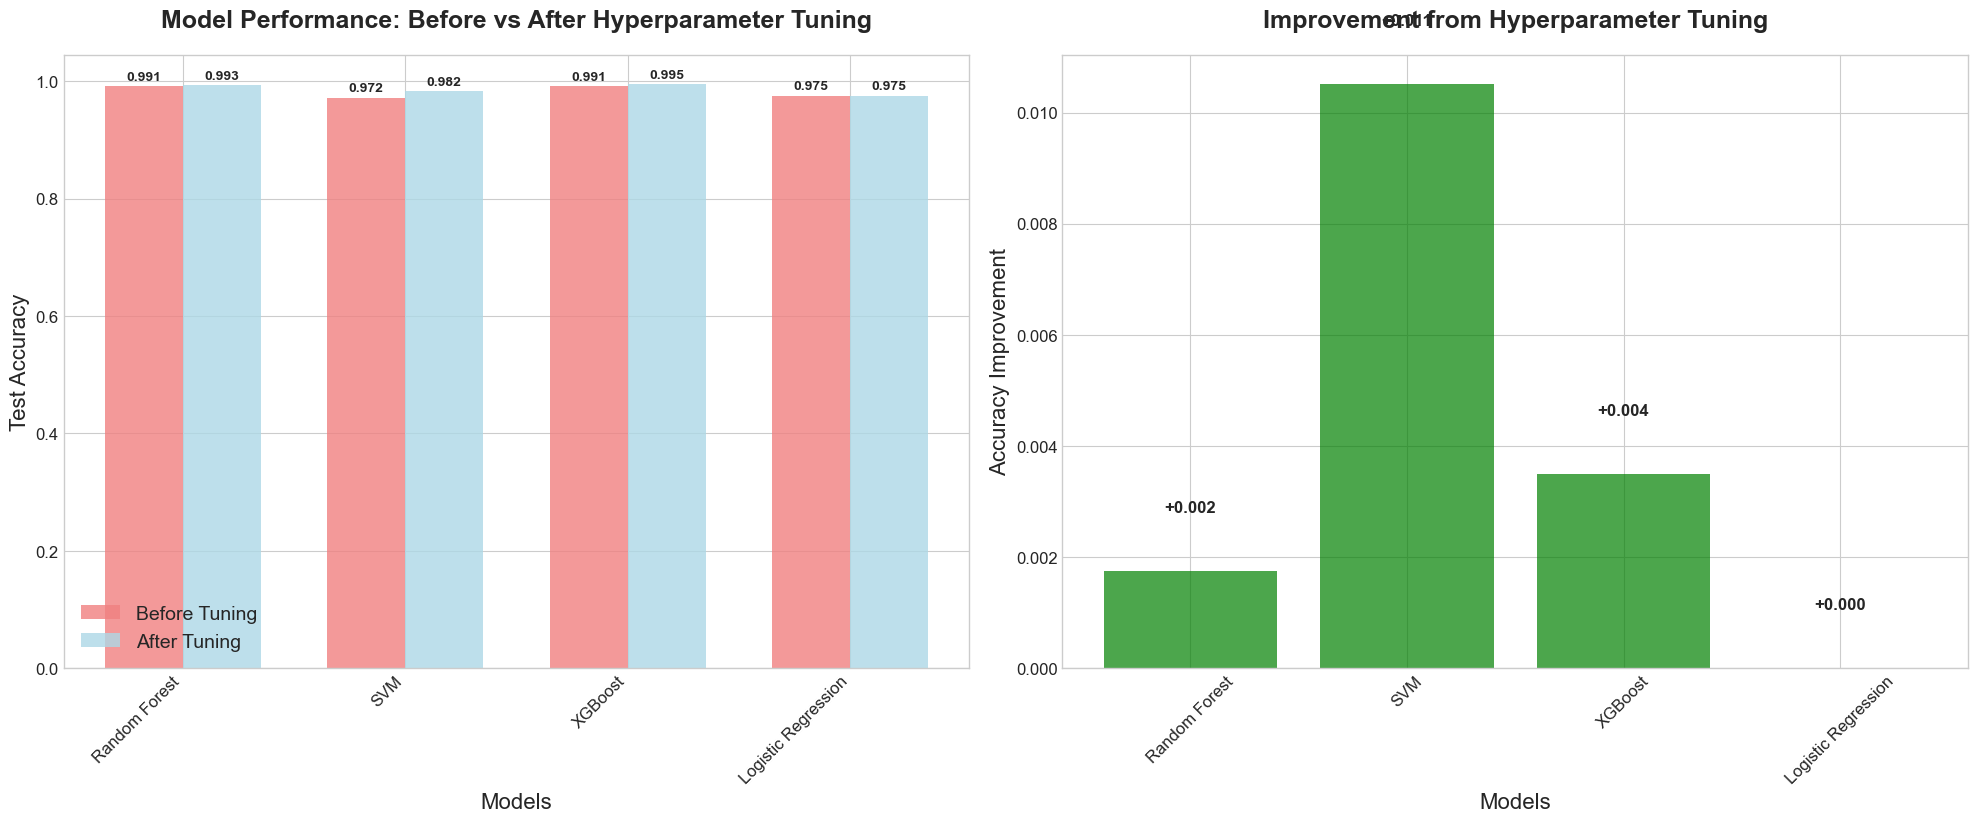



MODEL PERFORMANCE METRICS COMPARISON


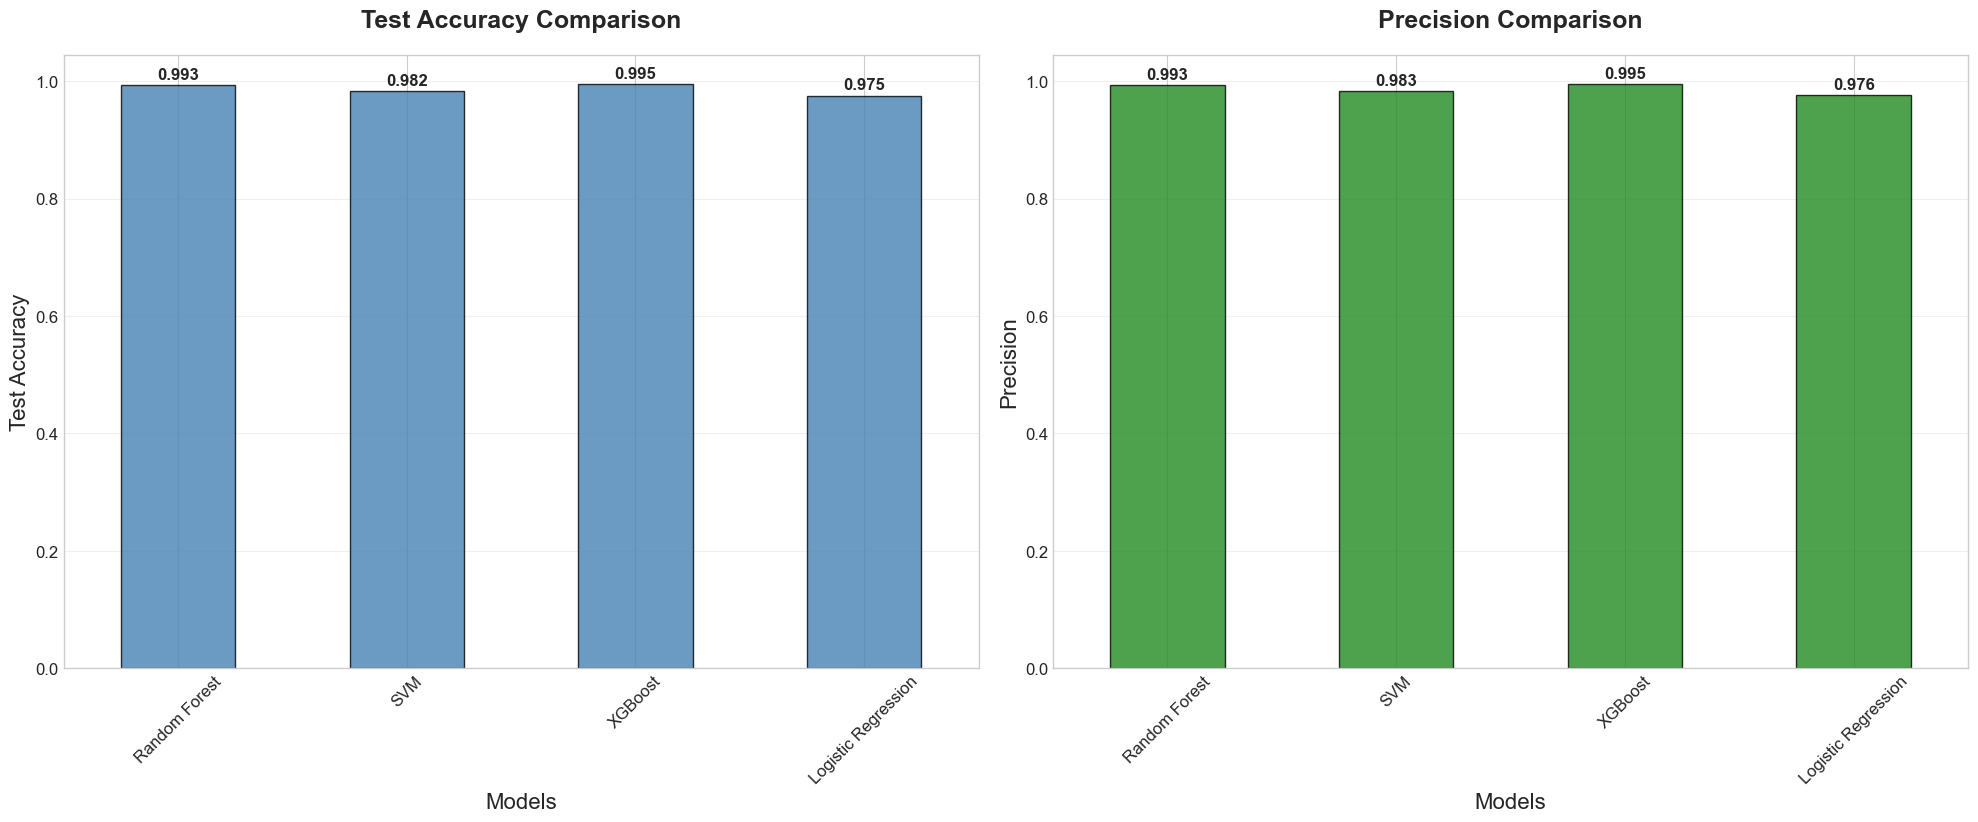


------------------------------



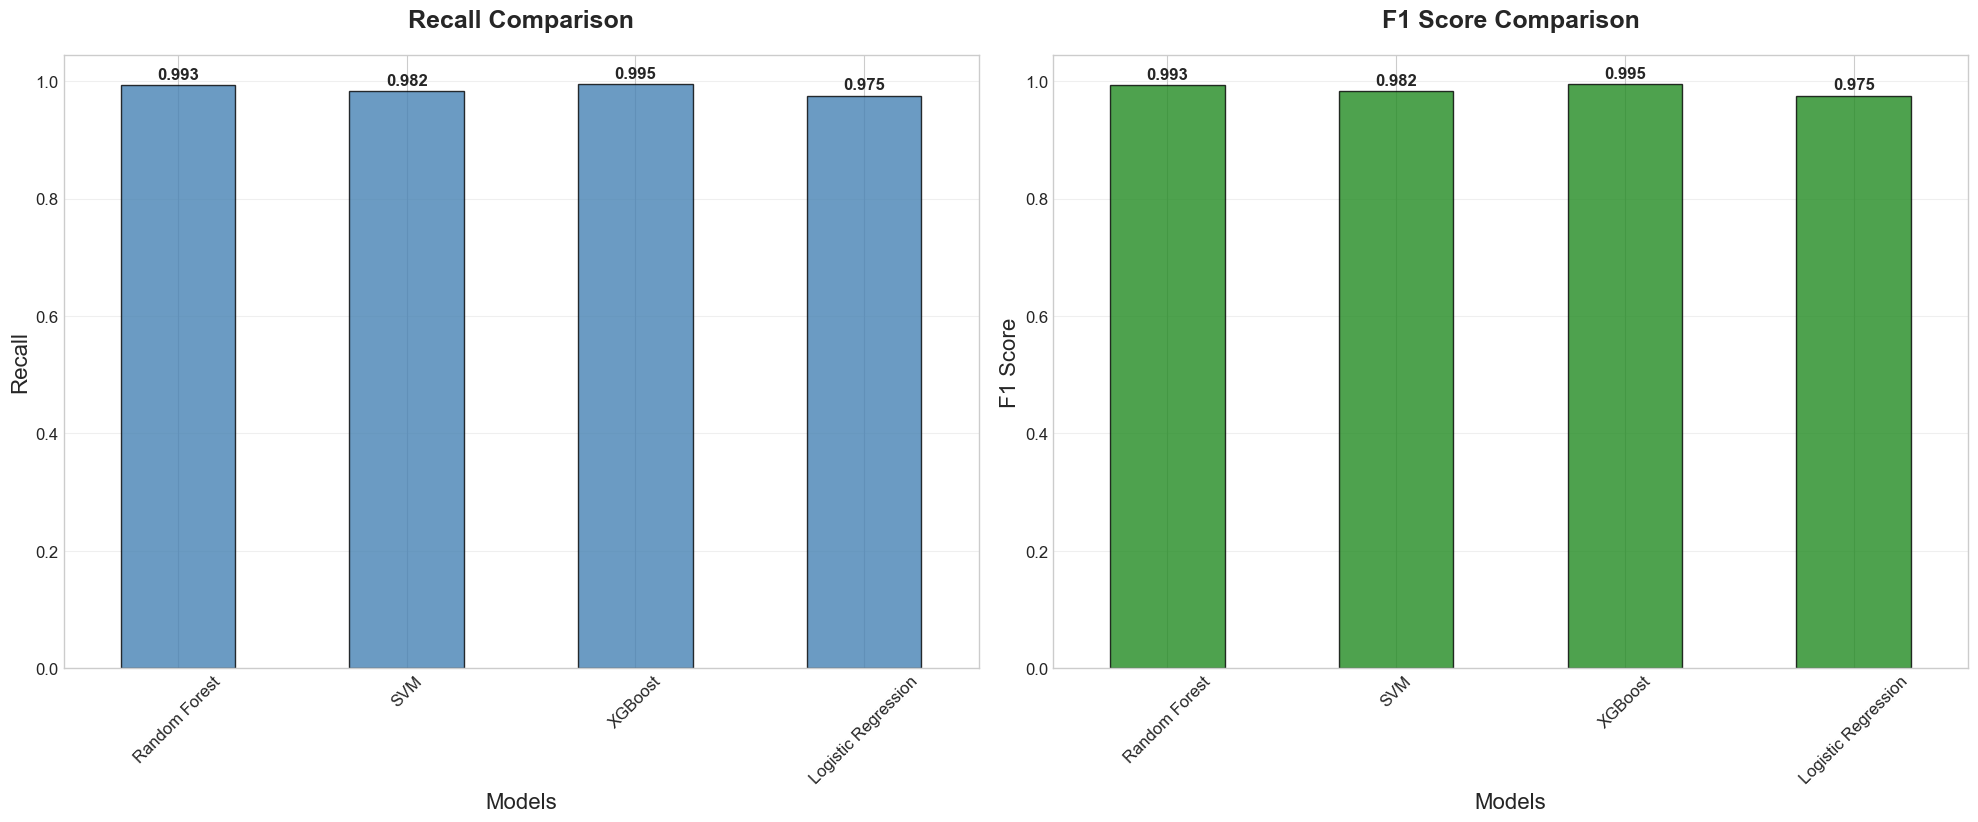


------------------------------



CROSS-VALIDATION SCORE DISTRIBUTION


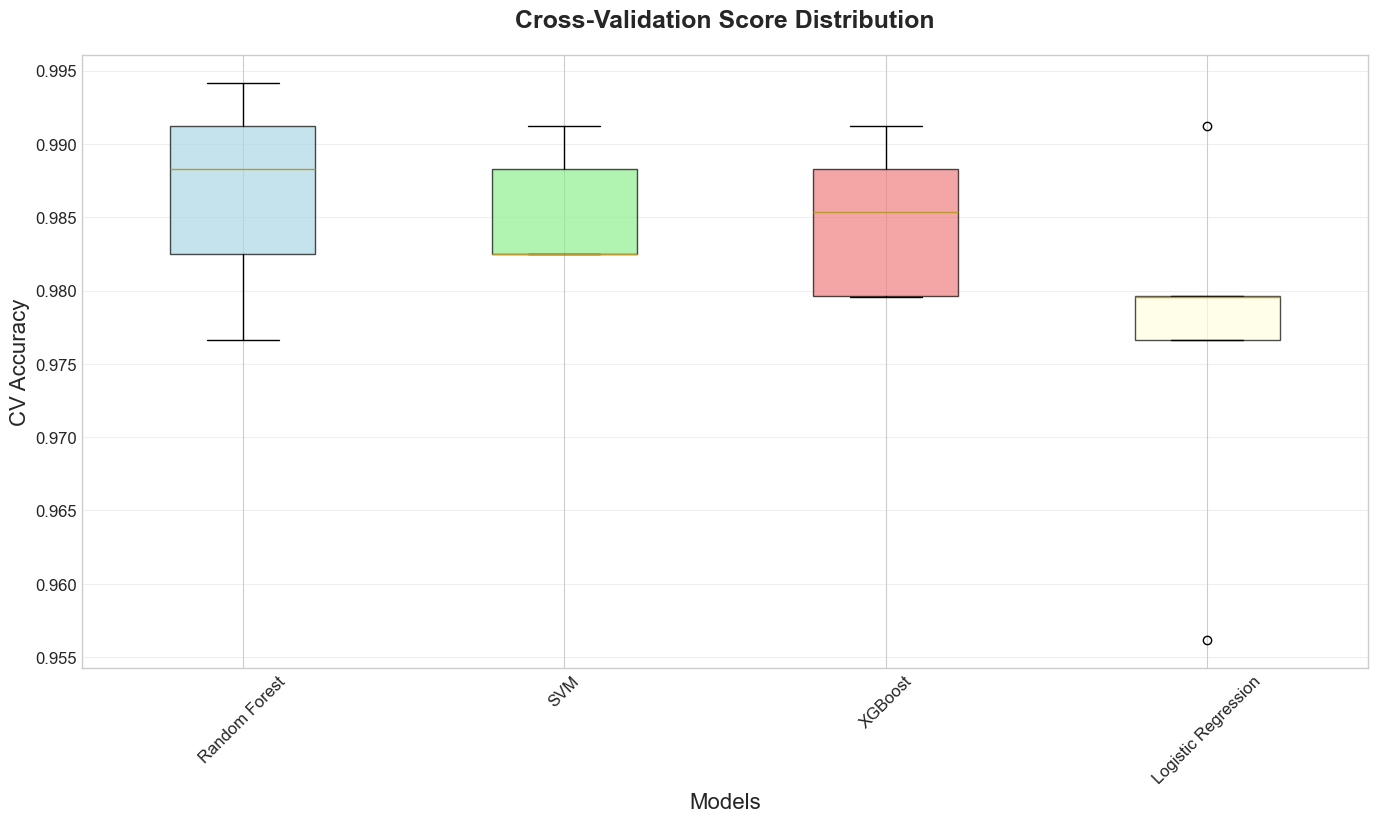



CONFUSION MATRIX ANALYSIS - BEFORE vs AFTER TUNING
Available models for comparison: ['Random Forest', 'SVM', 'XGBoost', 'Logistic Regression']

BEFORE HYPERPARAMETER TUNING:


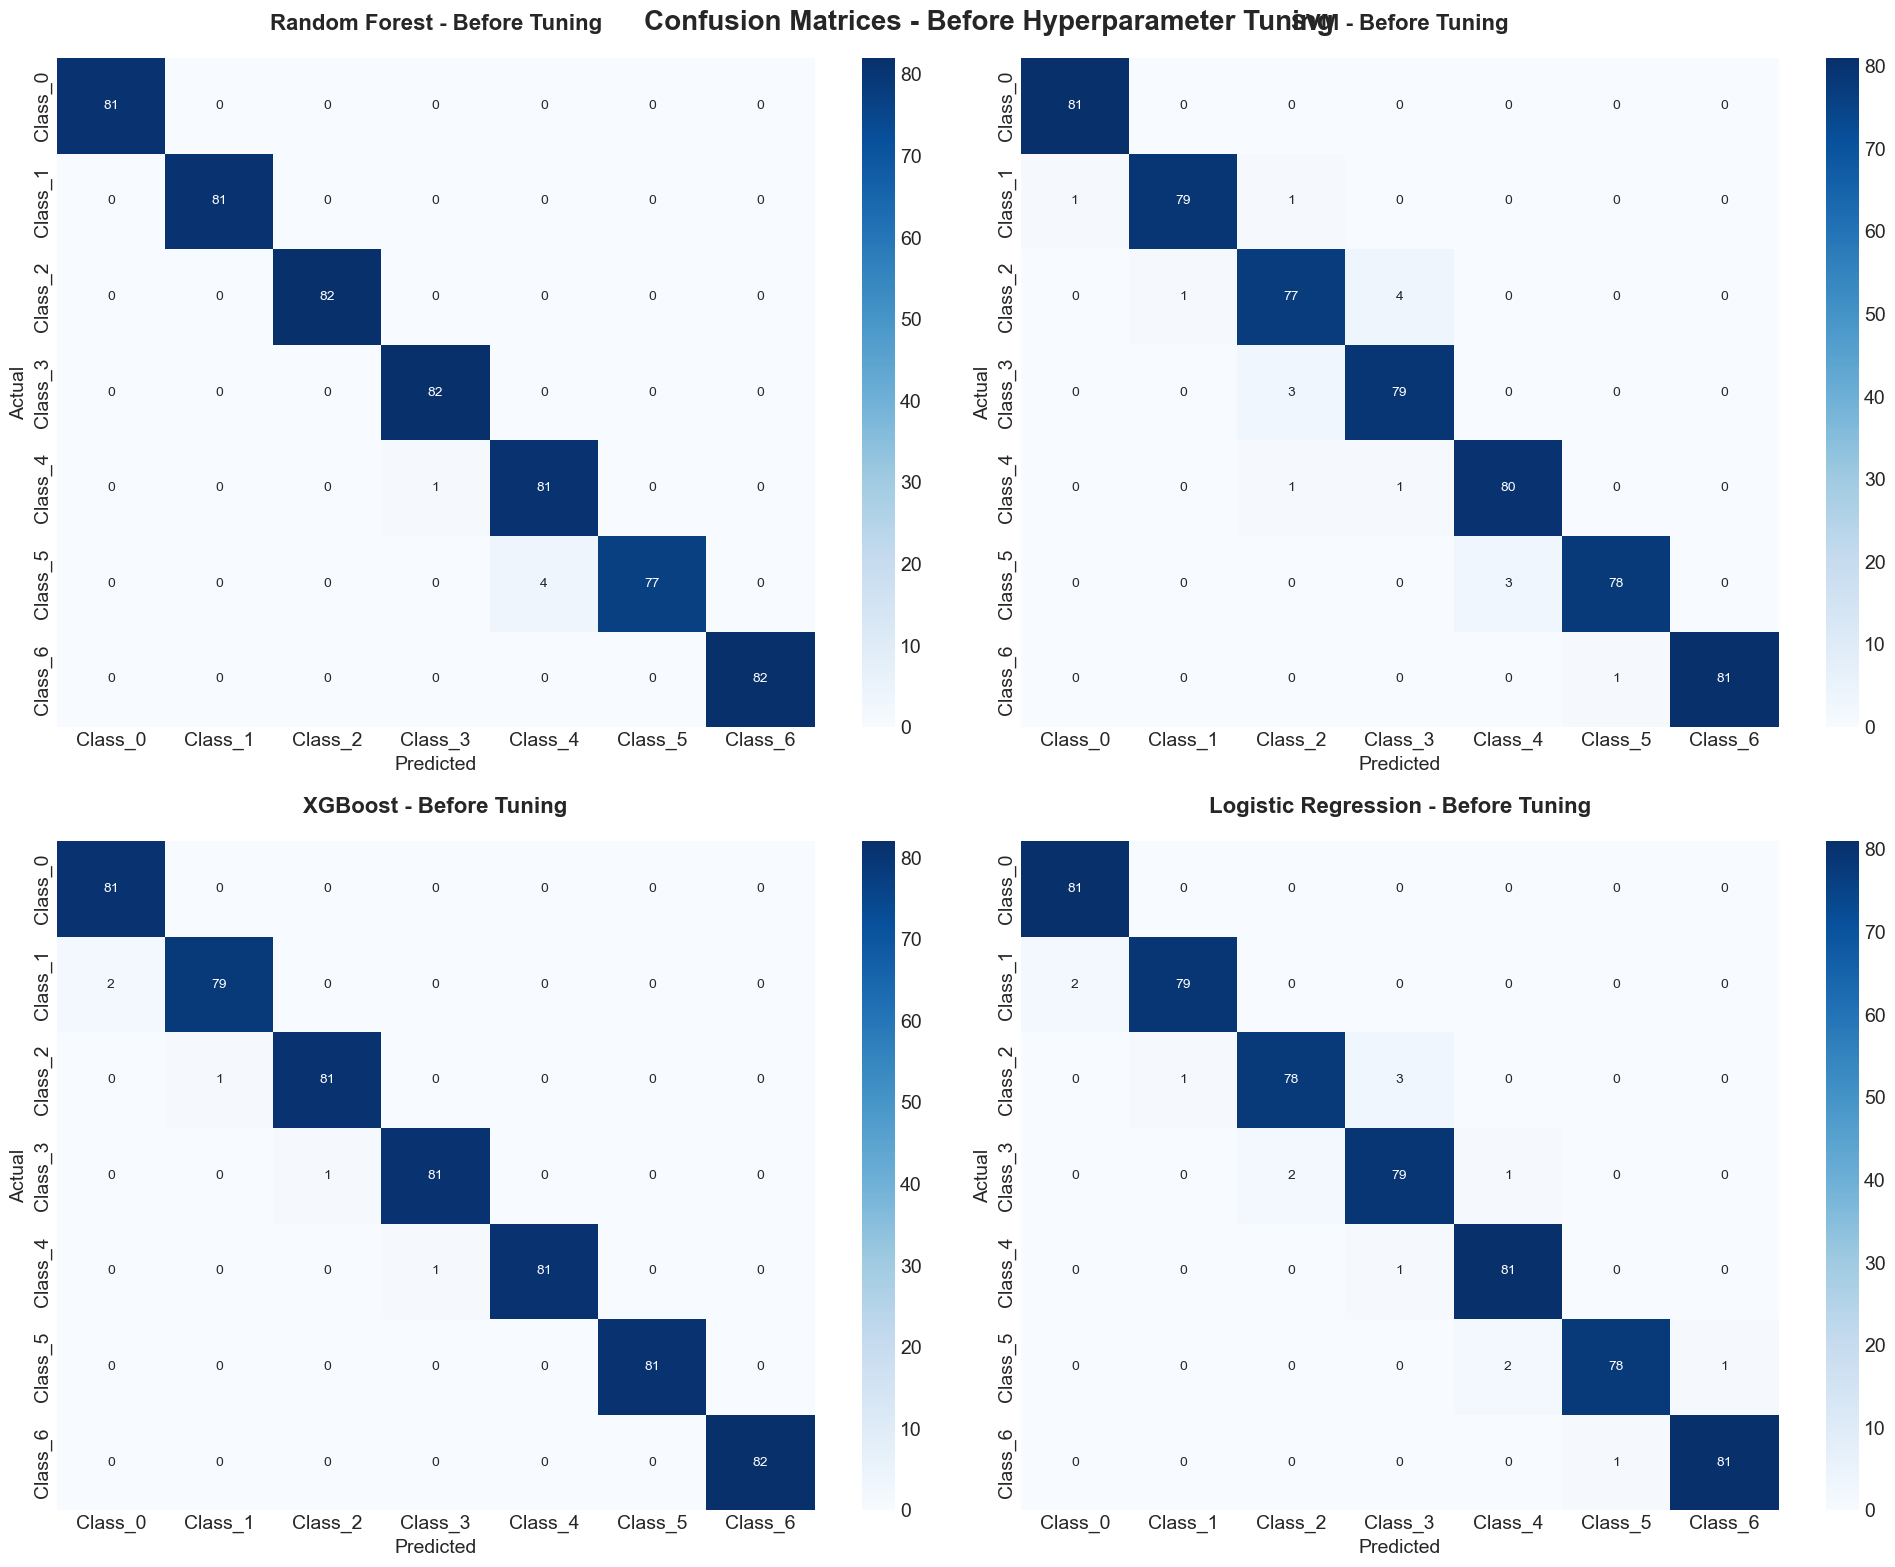


------------------------------------------------------------

AFTER HYPERPARAMETER TUNING:


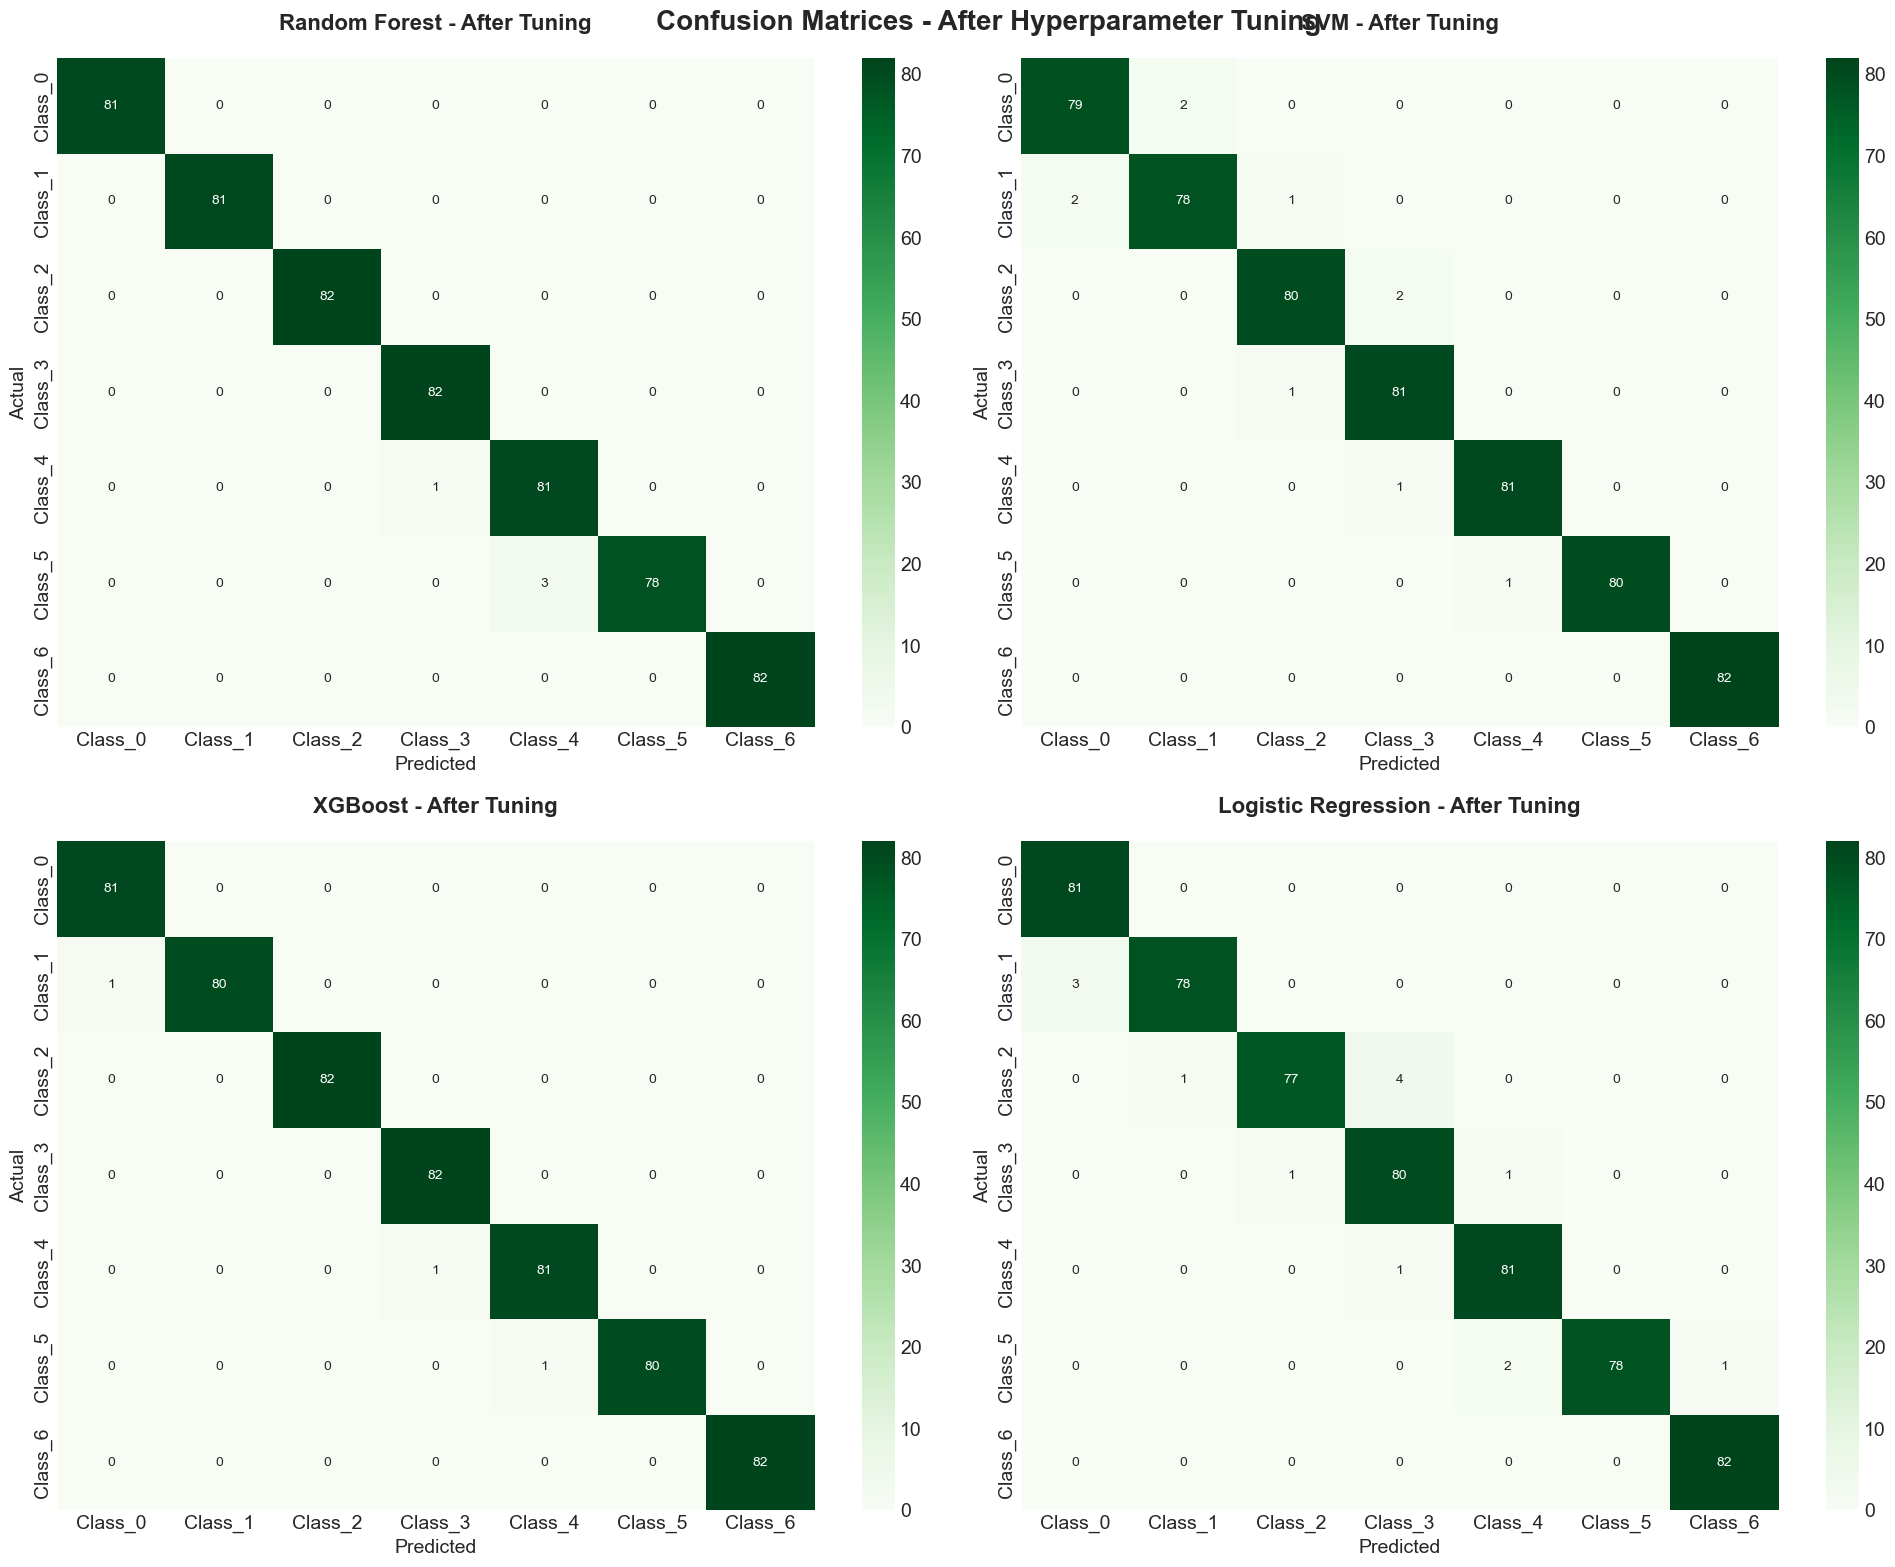

In [13]:
# Before vs After Tuning Visualization
print("\n" + "="*60)
print("HYPERPARAMETER TUNING IMPACT ANALYSIS")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Baseline vs Tuned comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, comparison_df['Baseline'], width, 
                label='Before Tuning', color='lightcoral', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, comparison_df['Tuned'], width,
                label='After Tuning', color='lightblue', alpha=0.8)

ax1.set_title('Model Performance: Before vs After Hyperparameter Tuning', 
              fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('Test Accuracy', fontsize=16)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right', fontsize=12)
ax1.legend(fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.005,
             f'{height1:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.005,
             f'{height2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Improvement visualization
bars3 = ax2.bar(comparison_df.index, comparison_df['Improvement'], 
                color='green', alpha=0.7)
ax2.set_title('Improvement from Hyperparameter Tuning', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Models', fontsize=16)
ax2.set_ylabel('Accuracy Improvement', fontsize=16)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Add value labels on bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'+{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("\n")

# Model performance metrics visualization - 2 plots per row
print("="*60)
print("MODEL PERFORMANCE METRICS COMPARISON")
print("="*60)

metrics_to_plot = [('test_accuracy', 'precision'), ('recall', 'f1_score')]

for metric_pair in metrics_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for i, metric in enumerate(metric_pair):
        bars = results_df[metric].plot(kind='bar', ax=axes[i], 
                                      color=['steelblue', 'forestgreen', 'coral', 'gold'][i % 4], 
                                      alpha=0.8, edgecolor='black')
        axes[i].set_title(f'{metric.replace("_", " ").title()} Comparison', 
                         fontsize=18, fontweight='bold', pad=20)
        axes[i].set_xlabel('Models', fontsize=16)
        axes[i].set_ylabel(metric.replace("_", " ").title(), fontsize=16)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(results_df[metric].values):
            axes[i].text(j, v + 0.005, f'{v:.3f}', ha='center', va='bottom', 
                        fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    print("\n" + "-"*30)
    print()

print("\n")

# Cross-validation score distribution analysis
print("="*60)
print("CROSS-VALIDATION SCORE DISTRIBUTION")
print("="*60)

fig, ax = plt.subplots(figsize=(14, 8))

# Get the CV scores from the models_results dictionary (they're stored there now)
rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')
svm_cv_scores = cross_val_score(svm_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')
lr_cv_scores = cross_val_score(lr_best, X_train, y_train, cv=cv_strategy, scoring='accuracy')

cv_data = pd.DataFrame({
    'Random Forest': rf_cv_scores,
    'SVM': svm_cv_scores,
    'XGBoost': xgb_cv_scores,
    'Logistic Regression': lr_cv_scores
})

box_plot = ax.boxplot([rf_cv_scores, svm_cv_scores, xgb_cv_scores, lr_cv_scores], 
                      labels=['Random Forest', 'SVM', 'XGBoost', 'Logistic Regression'],
                      patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Cross-Validation Score Distribution', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('CV Accuracy', fontsize=16)
ax.set_xlabel('Models', fontsize=16)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("\n")

# Confusion matrices - Before and After Tuning Comparison
print("="*80)
print("CONFUSION MATRIX ANALYSIS - BEFORE vs AFTER TUNING")
print("="*80)

# Check which models are available
available_models = [name for name in model_names if name in baseline_results and name in models_results]
print(f"Available models for comparison: {available_models}")

if len(available_models) > 0:
    # Before tuning confusion matrices
    print("\nBEFORE HYPERPARAMETER TUNING:")
    n_models = len(available_models)
    n_cols = 2
    n_rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8*n_rows))
    if n_models == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.ravel()

    target_names = [f'Class_{i}' for i in range(7)]
    baseline_predictions = [baseline_results[name]['predictions'] for name in available_models]

    for i, (model_name, pred) in enumerate(zip(available_models, baseline_predictions)):
        if i < len(axes):
            cm = confusion_matrix(y_test, pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                        xticklabels=target_names, yticklabels=target_names, annot_kws={'size': 10})
            axes[i].set_title(f'{model_name} - Before Tuning', fontsize=16, fontweight='bold', pad=20)
            axes[i].set_xlabel('Predicted', fontsize=14)
            axes[i].set_ylabel('Actual', fontsize=14)
    
    # Hide unused subplots
    for i in range(len(available_models), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('Confusion Matrices - Before Hyperparameter Tuning', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    print("\n" + "-"*60)
    print()

    # After tuning confusion matrices
    print("AFTER HYPERPARAMETER TUNING:")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8*n_rows))
    if n_models == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.ravel()

    # Get tuned predictions from models_results
    tuned_predictions = [models_results[name]['predictions'] for name in available_models]

    for i, (model_name, pred) in enumerate(zip(available_models, tuned_predictions)):
        if i < len(axes):
            cm = confusion_matrix(y_test, pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i],
                        xticklabels=target_names, yticklabels=target_names, annot_kws={'size': 10})
            axes[i].set_title(f'{model_name} - After Tuning', fontsize=16, fontweight='bold', pad=20)
            axes[i].set_xlabel('Predicted', fontsize=14)
            axes[i].set_ylabel('Actual', fontsize=14)
    
    # Hide unused subplots
    for i in range(len(available_models), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('Confusion Matrices - After Hyperparameter Tuning', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

print("\n")

FEATURE IMPORTANCE ANALYSIS
Top 10 Random Forest Feature Importance:
                        feature  importance
9                           BMI    0.214487
23          Weight_Height_Ratio    0.128275
33  BMI_WHO_Category_Overweight    0.080670
11                       Weight    0.077453
25     BMI_WHO_Category_Obese_I    0.068795
18      BMI_WHO_Category_Normal    0.068067
13    BMI_WHO_Category_Obese_II    0.055767
10       Age_Weight_Interaction    0.052217
26         Eating_Pattern_Score    0.039885
20                       Gender    0.034204

Top 10 XGBoost Feature Importance:
                        feature  importance
18      BMI_WHO_Category_Normal    0.317322
25     BMI_WHO_Category_Obese_I    0.270518
33  BMI_WHO_Category_Overweight    0.146396
9                           BMI    0.058309
13    BMI_WHO_Category_Obese_II    0.056509
20                       Gender    0.042905
26         Eating_Pattern_Score    0.019840
23          Weight_Height_Ratio    0.014561
0          Life

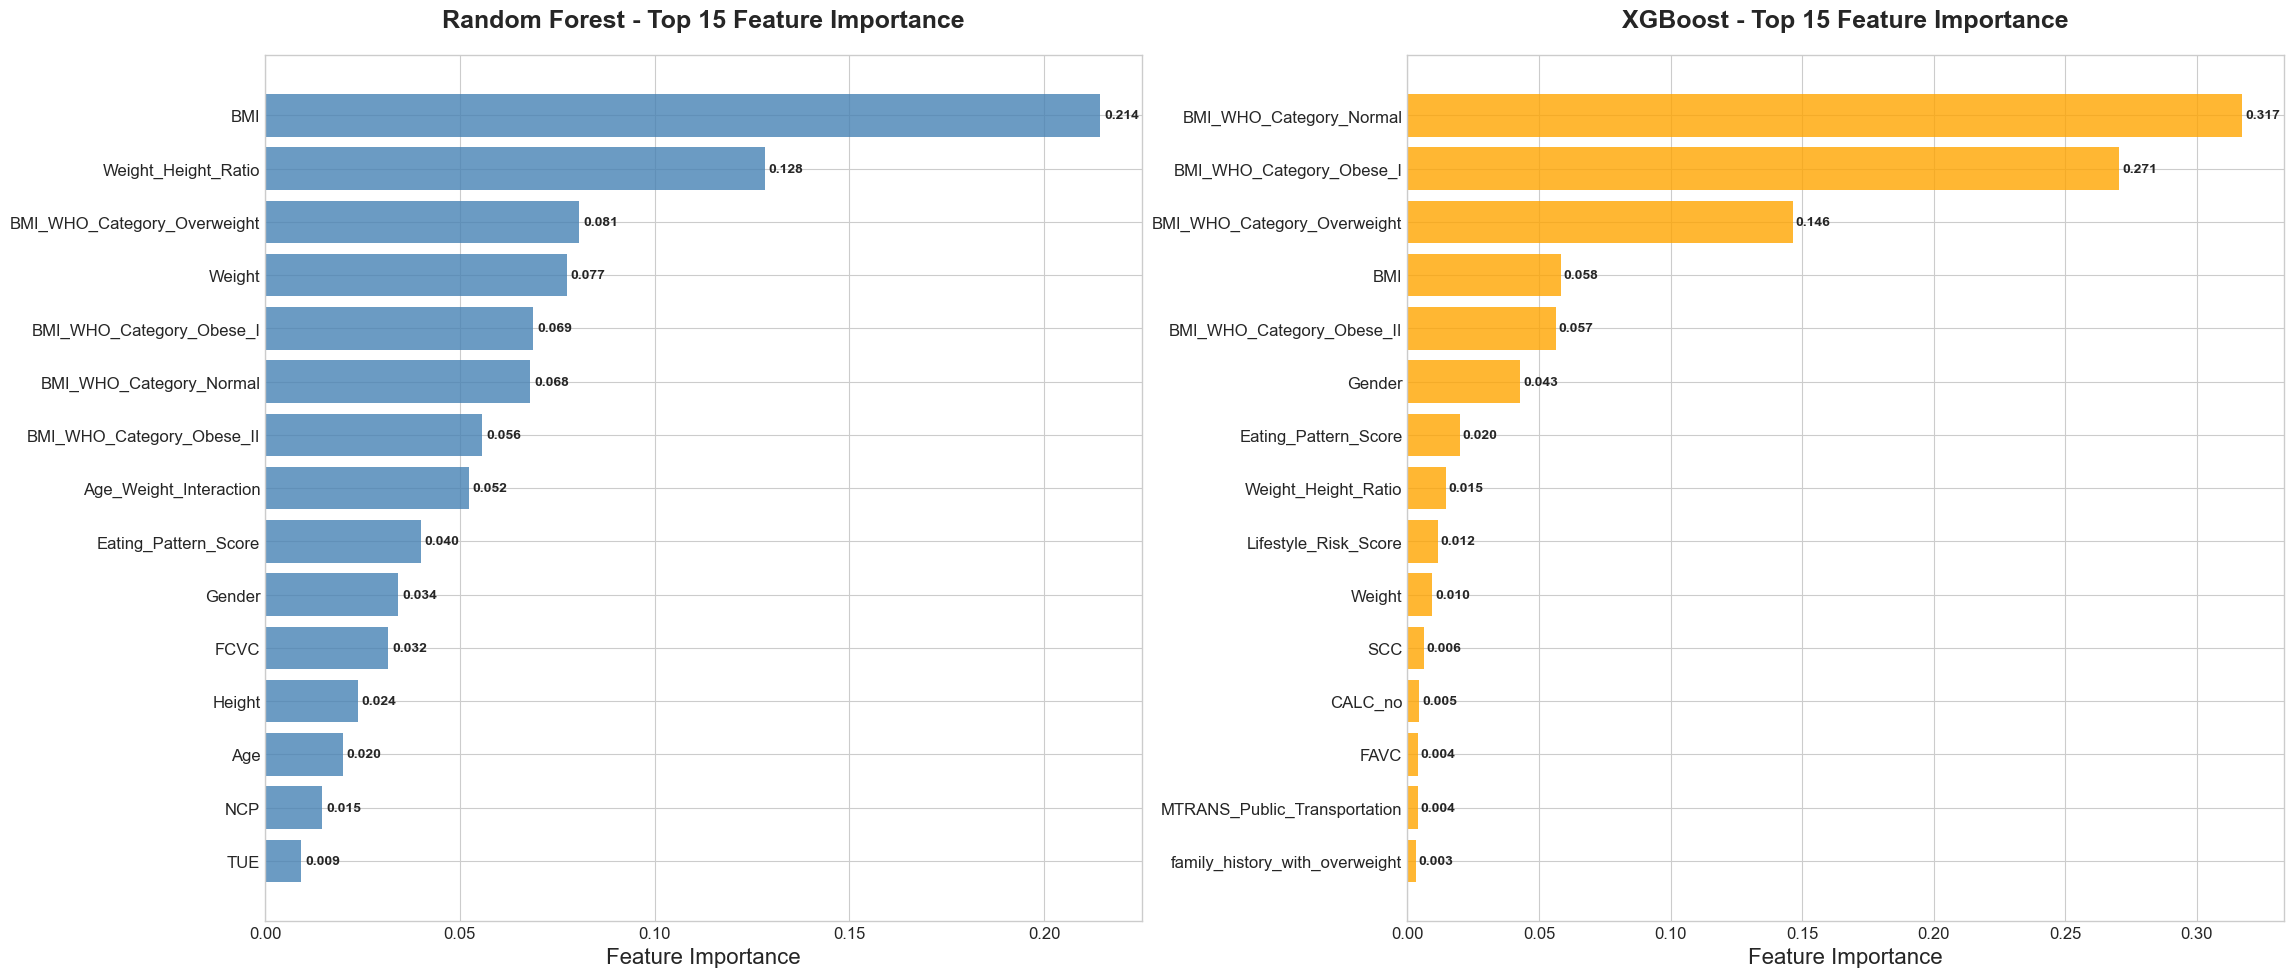

In [14]:
# Feature importance analysis for tree-based models
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

feature_importance_rf = pd.DataFrame({
    'feature': X_final.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_xgb = pd.DataFrame({
    'feature': X_final.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Random Forest Feature Importance:")
print(feature_importance_rf.head(10))
print("\nTop 10 XGBoost Feature Importance:")
print(feature_importance_xgb.head(10))

# Feature importance visualization - 2 plots per row
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

top_features_rf = feature_importance_rf.head(15)
bars1 = axes[0].barh(range(len(top_features_rf)), top_features_rf['importance'], color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(top_features_rf)))
axes[0].set_yticklabels(top_features_rf['feature'], fontsize=12)
axes[0].set_xlabel('Feature Importance', fontsize=16)
axes[0].set_title('Random Forest - Top 15 Feature Importance', fontsize=18, fontweight='bold', pad=20)
axes[0].invert_yaxis()
axes[0].tick_params(axis='x', labelsize=12)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0].text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

top_features_xgb = feature_importance_xgb.head(15)
bars2 = axes[1].barh(range(len(top_features_xgb)), top_features_xgb['importance'], color='orange', alpha=0.8)
axes[1].set_yticks(range(len(top_features_xgb)))
axes[1].set_yticklabels(top_features_xgb['feature'], fontsize=12)
axes[1].set_xlabel('Feature Importance', fontsize=16)
axes[1].set_title('XGBoost - Top 15 Feature Importance', fontsize=18, fontweight='bold', pad=20)
axes[1].invert_yaxis()
axes[1].tick_params(axis='x', labelsize=12)

# Add value labels on bars
for i, bar in enumerate(bars2):
    width = bar.get_width()
    axes[1].text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(left=0.15)
plt.show()

print("\n")

In [15]:
# Statistical significance testing between model performances
print("\n=== STATISTICAL SIGNIFICANCE TESTING ===")
model_scores = [rf_cv_scores, svm_cv_scores, xgb_cv_scores, lr_cv_scores]
model_pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
pair_names = [('RF','SVM'), ('RF','XGB'), ('RF','LR'), ('SVM','XGB'), ('SVM','LR'), ('XGB','LR')]

print("Paired t-test results for cross-validation scores:")
for (i,j), (name1, name2) in zip(model_pairs, pair_names):
    t_stat, p_value = ttest_rel(model_scores[i], model_scores[j])
    significance = "Significant" if p_value < 0.05 else "Not significant"
    print(f"{name1} vs {name2}: t-stat={t_stat:.4f}, p-value={p_value:.4f} ({significance})")

# Detailed classification reports
print("\n=== DETAILED CLASSIFICATION REPORTS ===")
tuned_predictions = [models_results[name]['predictions'] for name in available_models]
for model_name, pred in zip(available_models, tuned_predictions):
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, pred, digits=4))

# Optimal model identification
best_model_name = results_df['test_accuracy'].idxmax()
best_model_accuracy = results_df.loc[best_model_name, 'test_accuracy']

print(f"\n=== BEST MODEL SELECTION ===")
print(f"Best Performing Model: {best_model_name}")
print(f"Test Accuracy: {best_model_accuracy:.4f}")
print(f"Cross-validation mean: {results_df.loc[best_model_name, 'cv_mean']:.4f}")
print(f"Cross-validation std: {results_df.loc[best_model_name, 'cv_std']:.4f}")
print(f"Precision: {results_df.loc[best_model_name, 'precision']:.4f}")
print(f"Recall: {results_df.loc[best_model_name, 'recall']:.4f}")
print(f"F1-score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"Overfitting: {results_df.loc[best_model_name, 'overfitting']:.4f}")

model_mapping = {
    'Random Forest': rf_best,
    'SVM': svm_best,
    'XGBoost': xgb_best,
    'Logistic Regression': lr_best
}

final_model = model_mapping[best_model_name]
print(f"Best parameters: {results_df.loc[best_model_name, 'best_params']}")


=== STATISTICAL SIGNIFICANCE TESTING ===
Paired t-test results for cross-validation scores:
RF vs SVM: t-stat=0.5898, p-value=0.5870 (Not significant)
RF vs XGB: t-stat=0.8839, p-value=0.4267 (Not significant)
RF vs LR: t-stat=1.2282, p-value=0.2867 (Not significant)
SVM vs XGB: t-stat=0.2493, p-value=0.8154 (Not significant)
SVM vs LR: t-stat=1.3028, p-value=0.2626 (Not significant)
XGB vs LR: t-stat=1.1896, p-value=0.3000 (Not significant)

=== DETAILED CLASSIFICATION REPORTS ===

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        81
           1     1.0000    1.0000    1.0000        81
           2     1.0000    1.0000    1.0000        82
           3     0.9880    1.0000    0.9939        82
           4     0.9643    0.9878    0.9759        82
           5     1.0000    0.9630    0.9811        81
           6     1.0000    1.0000    1.0000        82

    accuracy                         0.9

In [16]:
# ================================================================================================
# DEPLOYMENT
# ================================================================================================
print("\n" + "="*80)
print("DEPLOYMENT PHASE")
print("="*80)

# Create artifacts directory if it doesn't exist
artifacts_dir = "../artifacts"
if not os.path.exists(artifacts_dir):
    os.makedirs(artifacts_dir)

# Production deployment artifact preparation
deployment_artifacts = {
    'final_model': final_model,
    'scaler': scaler,
    'selected_features': combined_features,
    'continuous_features': continuous_features,
    'target_mapping': {v: k for k, v in target_mapping.items()},
    'model_performance': results_df.to_dict(),
    'feature_importance_rf': feature_importance_rf.to_dict(),
    'feature_importance_xgb': feature_importance_xgb.to_dict(),
    'best_model_name': best_model_name
}

print("\n=== DEPLOYMENT ARTIFACTS PREPARATION ===")
print("Artifacts to be serialized:")
for artifact_name in deployment_artifacts.keys():
    print(f"- {artifact_name}")

# Serialization of deployment artifacts
print("\n=== SERIALIZING DEPLOYMENT ARTIFACTS ===")
for artifact_name, artifact_object in deployment_artifacts.items():
    filename = f"{artifact_name}.pkl"
    filepath = os.path.join(artifacts_dir, filename)
    
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(artifact_object, f)
        print(f"✓ Deployment artifact saved: {filepath}")
    except Exception as e:
        print(f"✗ Error saving {filepath}: {e}")

# Verification of serialized artifacts
print("\n=== VERIFYING SERIALIZED ARTIFACTS ===")
for artifact_name in deployment_artifacts.keys():
    filename = f"{artifact_name}.pkl"
    filepath = os.path.join(artifacts_dir, filename)
    
    try:
        with open(filepath, 'rb') as f:
            loaded_artifact = pickle.load(f)
        print(f"✓ Verified: {filepath} - Successfully loaded")
    except Exception as e:
        print(f"✗ Error verifying {filepath}: {e}")

# Final deployment summary
print(f"\n=== DEPLOYMENT SUMMARY ===")
print(f"Selected Model: {best_model_name}")
print(f"Model Accuracy: {best_model_accuracy:.4f}")
print(f"Features Utilized: {len(combined_features)}")
print(f"Training Samples: {len(X_train):,}")
print(f"Testing Samples: {len(X_test):,}")
print(f"Original Dataset Size: {data.shape[0]:,}")
print(f"Final Processed Dataset Size: {df_cleaned.shape[0]:,}")
print(f"Feature Engineering: {df_cleaned.shape[1] - data.shape[1]} new features created")
print(f"Class Balancing: SMOTE applied - {len(X_balanced):,} balanced samples")
print("Deployment Status: All artifacts successfully serialized for production use")
print(f"Artifacts Location: ./{artifacts_dir}/")

print("\n" + "="*80)
print("MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)


DEPLOYMENT PHASE

=== DEPLOYMENT ARTIFACTS PREPARATION ===
Artifacts to be serialized:
- final_model
- scaler
- selected_features
- continuous_features
- target_mapping
- model_performance
- feature_importance_rf
- feature_importance_xgb
- best_model_name

=== SERIALIZING DEPLOYMENT ARTIFACTS ===
✓ Deployment artifact saved: ../artifacts\final_model.pkl
✓ Deployment artifact saved: ../artifacts\scaler.pkl
✓ Deployment artifact saved: ../artifacts\selected_features.pkl
✓ Deployment artifact saved: ../artifacts\continuous_features.pkl
✓ Deployment artifact saved: ../artifacts\target_mapping.pkl
✓ Deployment artifact saved: ../artifacts\model_performance.pkl
✓ Deployment artifact saved: ../artifacts\feature_importance_rf.pkl
✓ Deployment artifact saved: ../artifacts\feature_importance_xgb.pkl
✓ Deployment artifact saved: ../artifacts\best_model_name.pkl

=== VERIFYING SERIALIZED ARTIFACTS ===
✓ Verified: ../artifacts\final_model.pkl - Successfully loaded
✓ Verified: ../artifacts\scaler.p